

En esta aplicación implementaremos un modelo de puntuación de riesgo poblacional a la mortalidad debido a los cánceres más comunes y su relación con las cantidades y tecnologías usadas en radioterapia por país.

# Como en este caso se usará Colab, no es necesario instalar librerías, pero sí cargarlas en este entorno. En esta primera celda, se cargarán todas las librerías necesarias para ejecutar el TFM del notebook.


In [82]:
#Cargo o importo pandas, numpy, Matplotlib,
import pandas as pd
import numpy as np

from urllib.parse import quote
import unicodedata
import matplotlib.pyplot as plt
import os

import statsmodels.api as sm


#lugar donde se van guardando las figuras
fig_dir = "figuras"
os.makedirs(fig_dir, exist_ok=True)

#########################



# Carga, Exploración y Preparación de los datos sobre equipos de radioterapia y pacientes
Se utilizará una base de datos de créditos DIRAC de la IAEA junto con los de la OMS, son datos reales, se buscará el año más actual posible con una cantidad de datos suficientes para hacer el estudio y que tenga lo menos posible la influencia del COVID-19.


Los datos pueden descargarse en la página de la IAEA en el apartado de DIRAC https://dirac.iaea.org/Query/Countries  donde aparecen reflejados los datos de los equipos de radioterapia y el año de sus ultimas actualizaciones a nivel the hardware, por otro lado, se descargaron los datos de la OMS, en el Global Cancer Observatory, donde se descargaron tanto las incidencias como las mortalidades por cáncer a nivel mundial https://gco.iarc.fr/overtime/en/dataviz/trends?populations=752&sexes=1_2&types=1&multiple_populations=1.
Asimismo, se descargó la información demográfica encontrada en la ONU en el apartado "United Nations World Population Prospects (WPP).



## Carga de datos

In [2]:
# Cargamos los datos

#Datos de los equipos y centros de radioterapia por país

url_dirac = (
    "https://raw.githubusercontent.com/mehrerm/TFM/main/"
    "data/raw/DIRAC_Countries.xlsx"
)

dirac = pd.read_excel(url_dirac)



# URL base del repositorio de tipos de cáncer más comunas por país
url_base = "https://raw.githubusercontent.com/mehrerm/TFM/main/data/raw/"

# Archivos
files_cancer = {
    "lung": "dataset-asr-inc-and-mort-males-and-females-lung.csv",
    "breast": "dataset-asr-inc-and-mort-males-and-females-breast.csv",
    "prostate": "dataset-asr-inc-and-mort-males-and-females-prostat.csv",
    "colon": "dataset-asr-inc-and-mort-males-and-females-colon.csv",
    "cervix": "dataset-asr-inc-and-mort-males-and-females-cervix-uterino.csv",
    "leukaemia": "dataset-asr-inc-and-mort-males-and-females-leukaemia.csv",
}

# Carga de datasets
dfd_cancer = []

for cancer, filename in files_cancer.items():
    url = url_base + quote(filename)
    df_cancer = pd.read_csv(url)



    dfd_cancer.append(df_cancer)

    print(f"{cancer.upper():10s} -> shape: {df_cancer.shape}")

df_all_cancer = pd.concat(dfd_cancer, ignore_index=True)


#Población mundial acorde con los datos de la ONU


url_pop = (
       "https://raw.githubusercontent.com/mehrerm/TFM/main/data/raw/"
       "WPP2024_TotalPopulationBySex.csv.gz"
)


pop = pd.read_csv(url_pop, compression='gzip')



LUNG       -> shape: (3280, 11)
BREAST     -> shape: (1640, 11)
PROSTATE   -> shape: (1640, 11)
COLON      -> shape: (3280, 11)
CERVIX     -> shape: (1640, 11)
LEUKAEMIA  -> shape: (3280, 11)


/tmp/ipython-input-4090968717.py:52: DtypeWarning: Columns (2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  pop = pd.read_csv(url_pop, compression='gzip')


## Análisis exploratorio

### Población global segun ONU

In [3]:
print(pop.head())
print(pop["LocTypeName"].unique())

   SortOrder  LocID Notes ISO3_code ISO2_code  SDMX_code  LocTypeID  \
0        NaN   5507   NaN       NaN       NaN        NaN        NaN   
1        NaN   5507   NaN       NaN       NaN        NaN        NaN   
2        NaN   5507   NaN       NaN       NaN        NaN        NaN   
3        NaN   5507   NaN       NaN       NaN        NaN        NaN   
4        NaN   5507   NaN       NaN       NaN        NaN        NaN   

  LocTypeName  ParentID                           Location  VarID Variant  \
0         NaN       NaN  ADB region: Central and West Asia      2  Medium   
1         NaN       NaN  ADB region: Central and West Asia      2  Medium   
2         NaN       NaN  ADB region: Central and West Asia      2  Medium   
3         NaN       NaN  ADB region: Central and West Asia      2  Medium   
4         NaN       NaN  ADB region: Central and West Asia      2  Medium   

   Time  MidPeriod    PopMale  PopFemale   PopTotal  PopDensity  
0  1950     1950.5  35880.164  33333.260  69

In [4]:

# Filtrar: países, escenario Medium
ONU_c = pop[
    (pop["LocTypeName"] == "Country/Area") &
    (pop["Variant"] == "Medium")
   # (pop["Time"].isin([2016, 2022]))

].copy()

# Seleccionar y renombrar columnas
ONU_c = (
    ONU_c[["Location", "Time", "PopTotal", "PopMale","PopFemale"]]
    .rename(columns={
    "Location": "Country_harmonized",
    "Time": "Year",
    "PopTotal": "Population",
    "PopMale": "Population_male",
    "PopFemale": "Population_female"
})
)

# Convertir tipos
ONU_c["Year"] = ONU_c["Year"].astype(int)

# PopTotal está en miles, pasar a personas
cols = ["Population", "Population_male", "Population_female"]
ONU_c[cols] = ONU_c[cols] * 1000

# Comprobaciones rápidas
print(ONU_c.shape)
print(ONU_c.head())

# Guardar CSV reducido
ONU_c.to_csv(
    "population_UN_WPP2024.csv",
    index=False
)

print(ONU_c["Country_harmonized"].unique())
ONU_c["Year"].unique()

(35787, 5)
       Country_harmonized  Year  Population  Population_male  \
336230            Burundi  1950   2254938.0        1080184.0   
336231            Burundi  1951   2305746.0        1105816.0   
336232            Burundi  1952   2355804.0        1130995.0   
336233            Burundi  1953   2405186.0        1155833.0   
336234            Burundi  1954   2454586.0        1180690.0   

        Population_female  
336230          1174755.0  
336231          1199930.0  
336232          1224809.0  
336233          1249353.0  
336234          1273896.0  
['Burundi' 'Comoros' 'Djibouti' 'Eritrea' 'Ethiopia' 'Kenya' 'Madagascar'
 'Malawi' 'Mauritius' 'Mayotte' 'Mozambique' 'Réunion' 'Rwanda'
 'Seychelles' 'Somalia' 'South Sudan' 'Uganda'
 'United Republic of Tanzania' 'Zambia' 'Zimbabwe' 'Angola' 'Cameroon'
 'Central African Republic' 'Chad' 'Congo'
 'Democratic Republic of the Congo' 'Equatorial Guinea' 'Gabon'
 'Sao Tome and Principe' 'Algeria' 'Egypt' 'Libya' 'Morocco' 'Sudan'
 'Tu

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026,
       2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037,
       2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048,
       2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059,
       2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070,
       2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081,
       2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092,
       2093, 2094, 2095, 2096, 2097, 2098, 2099, 21

In [5]:
#se ha realizado una exploración anticipada de los paises, y se ha detectado que
#varios han sido escritos de manera diferente a los de GLOBOCAN, por lo tanto,
#se reliza de una corrección de los nombres tanto para los de DIRAC como
#los de GLOBOCAN y ONU

country_mapping = {

    "Macau, China": "China",
    "Taiwan, China": "China",

    'Czech Republic': 'Czechia',

    "UK, England": "United Kingdom",
    "UK, Wales": "United Kingdom",
    "UK, Scotland": "United Kingdom",
    "UK, Northern Ireland": "United Kingdom",
    "UK, England and wales": "United Kingdom",


    "France (metropolitan)": "France",
    "France, Martinique": "Martinique",

    "USA": "United States of America",


    "Korea, Republic of": "South Korea",
    "Republic of Korea" : "South Korea",
    "Korea, Democratic People's Republic of": "North Korea",


    "Iran, Islamic Republic of": "Iran",
    "Iran (Islamic Republic of)": "Iran",

    "Viet Nam": "Vietnam",

    'Venezuela, Bolivarian Republic of': 'Venezuela',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',

    'Bolivia, Plurinational State of': 'Bolivia',
    'Bolivia (Plurinational State of)': 'Bolivia',

    "Netherlands, Kingdom of the": "The Netherlands",

    "Republic of Moldova": "Moldova"



}

In [6]:
# se limpian los paises de la onu


ONU_c["Country_harmonized"] = ONU_c["Country_harmonized"].replace(country_mapping)

ONU_c["Country_harmonized"] = ONU_c["Country_harmonized"].apply(
    lambda x: unicodedata.normalize("NFKD", x)
        .encode("ASCII", "ignore")
        .decode("utf-8") if pd.notna(x) else x
)

print(ONU_c['Country_harmonized'].unique())
print(ONU_c.info())
print(ONU_c.isna().sum().sum())
print(ONU_c['Year'].unique())


['Burundi' 'Comoros' 'Djibouti' 'Eritrea' 'Ethiopia' 'Kenya' 'Madagascar'
 'Malawi' 'Mauritius' 'Mayotte' 'Mozambique' 'Reunion' 'Rwanda'
 'Seychelles' 'Somalia' 'South Sudan' 'Uganda'
 'United Republic of Tanzania' 'Zambia' 'Zimbabwe' 'Angola' 'Cameroon'
 'Central African Republic' 'Chad' 'Congo'
 'Democratic Republic of the Congo' 'Equatorial Guinea' 'Gabon'
 'Sao Tome and Principe' 'Algeria' 'Egypt' 'Libya' 'Morocco' 'Sudan'
 'Tunisia' 'Western Sahara' 'Botswana' 'Eswatini' 'Lesotho' 'Namibia'
 'South Africa' 'Benin' 'Burkina Faso' 'Cabo Verde' "Cote d'Ivoire"
 'Gambia' 'Ghana' 'Guinea' 'Guinea-Bissau' 'Liberia' 'Mali' 'Mauritania'
 'Niger' 'Nigeria' 'Saint Helena' 'Senegal' 'Sierra Leone' 'Togo'
 'Kazakhstan' 'Kyrgyzstan' 'Tajikistan' 'Turkmenistan' 'Uzbekistan'
 'China' 'China, Hong Kong SAR' 'China, Macao SAR'
 'China, Taiwan Province of China' "Dem. People's Republic of Korea"
 'Japan' 'Mongolia' 'South Korea' 'Afghanistan' 'Bangladesh' 'Bhutan'
 'India' 'Iran' 'Maldives' 'Nepal


Los datos de población utilizados en este estudio proceden de la base World Population Prospects 2024 elaborada por la División de Población del Departamento de Asuntos Económicos y Sociales de las Naciones Unidas (ONU). Según la metodología oficial de esta fuente, las estimaciones de población se basan en datos observados provenientes de censos nacionales, registros vitales y encuestas demográficas, mientras que las proyecciones de población comienzan a partir del año 2024.

Aunque el conjunto de datos incluye estimaciones hasta el año 2023, la disponibilidad y calidad de los datos demográficos recientes varía considerablemente entre países. En muchos casos, los últimos censos o registros vitales utilizados como base empírica corresponden a años anteriores, especialmente en el periodo posterior a la pandemia de COVID-19. Como consecuencia, los valores más recientes incorporan un mayor grado de interpolación y ajuste modelizado.

Por este motivo, y con el objetivo de evitar el uso de datos proyectados o altamente modelizados, y debido a las exploraciones posteriores con el resto de nuestras fuentes de datos, en este trabajo se selecciona el año 2022 como el año más reciente con una cobertura amplia y consistente de datos poblacionales basados mayoritariamente en información observada. Esta elección permite garantizar una mayor comparabilidad internacional y una mayor robustez metodológica en los análisis realizados.

La utilización del año 2022 resulta, además, especialmente adecuada para su integración con los datos de mortalidad por cáncer de GLOBOCAN y los datos de infraestructura de radioterapia del registro DIRAC, que presentan una mayor disponibilidad y estabilidad en torno a ese periodo temporal. De este modo, la fusión de las tres fuentes se realiza minimizando sesgos del uso de proyecciones demográficas.

In [7]:
dirac.head()



,Country,Region Name,RTCenters With RT,He Photon And Electron Beam Rt,Proton Ion Therapy,XRay Generator,Brachy Therapy Inc El,Last Update
0,Albania,Southern Europe,3,5,0,1,0,2025
1,Algeria,Northern Africa,15,37,0,0,9,2023
2,Angola,Middle Africa,2,3,0,0,1,2023
3,Argentina,South America,89,131,0,8,47,2025
4,Armenia,Western Asia,2,5,0,0,3,2025


In [8]:
dirac.shape

(156, 8)

In [9]:
dirac.columns


Index(['Country', 'Region Name', 'RTCenters With RT',
       'He Photon And Electron Beam Rt', 'Proton Ion Therapy',
       'XRay Generator', 'Brachy Therapy Inc El', 'Last Update'],
      dtype='object')

In [10]:
dirac.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Country                         155 non-null    object
 1   Region Name                     155 non-null    object
 2   RTCenters With RT               156 non-null    int64 
 3   He Photon And Electron Beam Rt  156 non-null    int64 
 4   Proton Ion Therapy              156 non-null    int64 
 5   XRay Generator                  156 non-null    int64 
 6   Brachy Therapy Inc El           156 non-null    int64 
 7   Last Update                     156 non-null    object
dtypes: int64(5), object(3)
memory usage: 9.9+ KB


##Variables encontradas
Entonces, con estos datos se tiene lo siguiente:

'Country' = país al que corresponde la información

'Region Name' = región geográfica o continental en la que se localiza el país.

'RTCenters With RT' = número de centros que disponen de al menos un equipo de radioterapia.

'He Photon And Electron Beam Rt' = número de centros con equipos de teleterapia que utilizan haces de fotones y electrones.

'Proton Ion Therapy'= número de centros con disponibilidad de protonterapia.

'XRay Generator' = número de generadores de rayos X utilizados con fines terapéuticos.

'Brachy Therapy Inc El' = número de equipos de braquiterapia, incluyendo tanto fuentes radiactivas como sistemas de braquiterapia electrónica mediante generadores miniaturizados de rayos X.

'Last Update' = año de la última actualización de la información registrada para cada país.

Las variables pueden clasificarse en cualitativas nominales, cuantitativas discretas y una variable temporal, lo que permite realizar posteriormente un análisis exploratorio orientado a la detección de valores atípicos (outliers) y a la normalización por población.
Con esta primera exploración se encuentra que no hay datos nulos, se tiene un conjunto de datos cualitativos nominales, com el país y la región, y una variable temporal correspondiente a la fecha de la ultima actialización, asimismo se tienen variables cuantitativas discretas donde están el número de centros y equipos de tratamiento.

Ahora se realiza un análisis exploratorio para buscar outliers, si es que los hay.




In [11]:
categ_vars = dirac.select_dtypes(include='object').columns


In [12]:
#se eliminan espacios al inicio o final de cada nombre
#for col in categ_vars:
 #   dirac[col] = dirac[col].str.strip()


for col in categ_vars:
    print(f"Valores únicos en {col}:")
    print(dirac[col].unique())
    print("-" * 40)

Valores únicos en Country:
['Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia' 'Aruba' 'Australia'
 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados'
 'Belarus' 'Belgium' 'Bermuda' 'Bolivia, Plurinational State of'
 'Bosnia and Herzegovina' 'Botswana' 'Brazil' 'Brunei Darussalam'
 'Bulgaria' 'Burkina Faso' 'Cambodia' 'Cameroon' 'Canada' 'Chile' 'China'
 'Colombia' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czech Republic'
 "Côte d'Ivoire" 'Dem. P.R. of Korea' 'Democratic Republic of the Congo'
 'Denmark' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Estonia'
 'Ethiopia' 'Finland' 'France' 'Gabon' 'Georgia' 'Germany' 'Ghana'
 'Greece' 'Guadeloupe' 'Guatemala' 'Guyana' 'Honduras' 'Hungary' 'Iceland'
 'India' 'Indonesia' 'Iran, Islamic Republic of' 'Iraq' 'Ireland' 'Israel'
 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan' 'Kenya'
 'Korea, Republic of' 'Kuwait' 'Kyrgyzstan'
 "Lao People's Democratic Republic" 'Latvia' 'Lebanon' 'Libya' 'Lithuania'
 'Luxembourg' 'Macau

En este primera análisis exploratorio, parece que existen unos valores anómalos, se explora entonces qué información existe cuando se trata de "nan" y "Latest: 2025"

In [13]:
dirac[dirac['Last Update'] == 'Latest: 2025']





,Country,Region Name,RTCenters With RT,He Photon And Electron Beam Rt,Proton Ion Therapy,XRay Generator,Brachy Therapy Inc El,Last Update
155,NaN,NaN,8620,17162,133,706,3359,Latest: 2025


Esto parece más bien que es la última fila con todos los equipos.

In [14]:
dirac['Country'].isna().sum()

np.int64(1)

In [15]:
dirac["Region Name"].isna().sum()

np.int64(1)

Con esto se demuestra que estos valores anómalos están en la última fila por consecuencia de sumar todos los equipos y centros y calcular la última actualización, entonces, esta fila se eliminará de los datos. Otra operación que sería interesante modificar son los nombres con caracteres que nos podría dar problemas, así como asegurarse de que no hay paises repetidos.

In [16]:
dirac = dirac.drop(index=155)
#queda eliminada la ultima fila
dirac = dirac.drop(columns=["Region name"], errors="ignore")
#Ya que el análisis será por país, ya luego se verá si la región tiene sentido.

dirac['Country'].value_counts().sort_values(ascending=False)


,count
Country,
Albania,1
Algeria,1
Angola,1
Argentina,1
Armenia,1
...,...
"Venezuela, Bolivarian Republic of",1
Viet Nam,1
Yemen,1


In [17]:


dirac["Country_harmonized"] = dirac["Country"].replace(country_mapping)

dirac["Country_harmonized"] = dirac["Country_harmonized"].apply(
    lambda x: unicodedata.normalize("NFKD", x)
        .encode("ASCII", "ignore")
        .decode("utf-8") if pd.notna(x) else x
)


Debido a que hay países que están segregados por zonas, se unificará usando Country_harmonized.

Durante el proceso de armonización geográfica se identificaron territorios no soberanos, como Martinica, que inicialmente se consideraron candidatos a ser integrados bajo el Estado correspondiente (Francia). No obstante, un análisis exploratorio de los datos epidemiológicos reveló diferencias sustanciales entre Francia y Martinica en las variables clave de GLOBOCAN, tales como la tasa estandarizada por edad (ASR World), la tasa bruta, el riesgo acumulado y el número total de casos. Por lo tanto, se usarán por separado, algo que no ocurre con UK, donde todo el territorio tiene resultados estadísticos similares.

Adicionalmente, se constató que ambas fuentes de datos empleadas en este estudio, GLOBOCAN y DIRAC, proporcionan información diferenciada para Martinica y Francia. En consecuencia, y con el fin de preservar la coherencia interna de los datos y evitar la introducción de sesgos derivados de agregaciones no justificadas, se decidió mantener Martinica como una entidad separada en el análisis.


In [18]:
# Comprobar duplicados por país
n_dups = dirac["Country_harmonized"].duplicated().sum()

if n_dups > 0:
    num_cols = dirac.select_dtypes(include="number").columns.tolist()

    # Last Update NO se suma, se queda el más reciente
    if "Last Update" in num_cols:
        num_cols.remove("Last Update")

    dirac_clean = (
        dirac
        .groupby("Country_harmonized", as_index=False)
        .agg(
            {**{c: "sum" for c in num_cols},
             "Last Update": "max"}
        )
    )
else:
  dirac_clean = dirac.copy()


dirac_clean["Country_harmonized"].duplicated().sum()




np.int64(0)

Dado que el único campo no numérico del conjunto DIRAC corresponde al año de la última actualización, no fue necesario aplicar reglas de agregación adicionales para variables categóricas.

In [19]:
dirac_clean['Country_harmonized'].unique()

array(['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Bermuda',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Cambodia',
       'Cameroon', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia',
       'Dem. P.R. of Korea', 'Democratic Republic of the Congo',
       'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Estonia', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Georgia',
       'Germany', 'Ghana', 'Greece', 'Guadeloupe', 'Guatemala', 'Guyana',
       'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran',
       'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan',
       'Kazakhstan', 'Kenya', 'Kuwait', 'Kyrgyzstan',
       "Lao People's Democratic Republi

Se ha limpiado de caracteres anómalos.
Con losdatos numéricos entonces, se analiza si existe algun dato anomalo

In [20]:
datos_numericos = dirac_clean.select_dtypes(include=['int64'])

datos_numericos.describe().T



,count,mean,std,min,25%,50%,75%,max
RTCenters With RT,153.0,56.339869,237.468784,1.0,2.0,6.0,25.0,2237.0
He Photon And Electron Beam Rt,153.0,112.169935,419.628623,1.0,3.0,16.0,57.0,3892.0
Proton Ion Therapy,153.0,0.869281,4.397506,0.0,0.0,0.0,0.0,44.0
XRay Generator,153.0,4.614379,16.112321,0.0,0.0,0.0,1.0,124.0
Brachy Therapy Inc El,153.0,21.954248,67.180662,0.0,1.0,3.0,14.0,638.0


Con estos resultados, se puede saber que hay paises con valores extremos y otros donde escasamente hay un solo equipo. Se puede ver que hay paises donde es cero en equipos mientras que otros tienen hasta 2237 centros con radioterapia, esto tiene sentido si se explora que paises son.


In [21]:
# Lista de variables que representan centros/equipos
columnas_equipos = [
    'RTCenters With RT',
    'He Photon And Electron Beam Rt',
    'Proton Ion Therapy',
    'XRay Generator',
    'Brachy Therapy Inc El'
]

# Mostrar el Top 5 por cada columna
for col in columnas_equipos:
    print(f"\n Top 5 países por: {col}")
    top5 = dirac_clean[['Country_harmonized', col]].sort_values(by=col, ascending=False).head(5)
    print(top5.to_string(index=False))




 Top 5 países por: RTCenters With RT
      Country_harmonized  RTCenters With RT
United States of America               2237
                   China               1699
                   Japan                759
                   India                464
                 Germany                307

 Top 5 países por: He Photon And Electron Beam Rt
      Country_harmonized  He Photon And Electron Beam Rt
United States of America                            3892
                   China                            3090
                   Japan                            1067
                   India                             793
                 Germany                             587

 Top 5 países por: Proton Ion Therapy
      Country_harmonized  Proton Ion Therapy
United States of America                  44
                   Japan                  24
                   China                  19
                 Germany                   7
          United Kingdom                 

In [22]:
dirac_clean.head()

,Country_harmonized,RTCenters With RT,He Photon And Electron Beam Rt,Proton Ion Therapy,XRay Generator,Brachy Therapy Inc El,Last Update
0,Albania,3,5,0,1,0,2025
1,Algeria,15,37,0,0,9,2023
2,Angola,2,3,0,0,1,2023
3,Argentina,89,131,0,8,47,2025
4,Armenia,2,5,0,0,3,2025


Con estos resultados es necesario tener entonces los datos demograficos por país, ademas de los datos de cancer.
#Ahora, a explorar y depurar los datos provenientes de GLOBOCAN.

Para esto, se ha tomado seis tipos de cancer muy comunes: Pulmon, mama, prostata, colon, cervix y leucemia.

In [23]:
df_all_cancer.shape

df_all_cancer["Cancer label"].unique()


array(['Lung', 'Breast', 'Prostate', 'Colon', 'Cervix uteri', 'Leukaemia'],
      dtype=object)

Se puede observar que para un cáncer como el que afecta exclusivamente un sexo de la población , los datos son la mitad (1640 filas) del resto donde se toma en cuenta ambos sexos (3280 filas). En el caso de Estados Unidos, GLOBOCAN proporciona información adicional desagregada por grupos poblacionales (p. ej., “USA: White” y “USA: Black”), además de los datos correspondientes al total nacional. Dado que estas categorías no representan unidades geográficas independientes y que el conjunto de datos incluye la población total, dichas desagregaciones se excluyeron del análisis para evitar duplicidades y distorsiones en los indicadores epidemiológicos.

Los distintos conjuntos de datos correspondientes a cada tipo de cáncer se integraron en un único dataframe, incorporando una variable identificadora del tipo de cáncer para facilitar el análisis conjunto.
Los datos oncológicos incluyen tanto incidencia como mortalidad, diferenciadas mediante la variable Type. Para los análisis comparativos entre países se emplean principalmente las tasas estandarizadas por edad (ASR (World)), al permitir comparaciones internacionales independientes de la estructura demográfica.

Como este dataset tiene mezclados los casos de incidencias con mortalidad, dependiendo de la columna, puede tener significados distintos.

Cancer id: Identificador numérico interno del tipo de cáncer.

Cancer label: Nombre del tipo de cáncer analizado.

Country label: País al que corresponden los datos.

Sex: Sexo de la población considerada (1 hombre, 2 mujer).

Year: Año de referencia del dato epidemiológico.

Type: Tipo de medida epidemiológica, diferenciando entre incidencia y mortalidad (0 incidencia, 1 mortalidad).

ASR (World): Tasa estandarizada por edad según la población estándar mundial, expresada por 100.000 habitantes.

Crude rate: Tasa bruta de incidencia o mortalidad por 100.000 habitantes, no ajustada por edad.

Cumulative risk: Riesgo acumulado de desarrollar o morir por el cáncer hasta una edad determinada.

Total:

Antes de elegir un año, se procede con la depuración de los datos.
Primeramente se eliminan las que son las menos relevantes, como por ejemplo el cancer id y population id.

In [24]:
df_all_cancer = df_all_cancer.drop(columns=["Cancer id", "Population id"], errors="ignore")




In [25]:

print(df_all_cancer.info())


for col in df_all_cancer:
    print(f"\n {col}")
    print(df_all_cancer[col].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14760 entries, 0 to 14759
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Cancer label     14760 non-null  object 
 1   Country label    14760 non-null  object 
 2   Sex              14760 non-null  int64  
 3   Type             14760 non-null  int64  
 4   Year             14760 non-null  int64  
 5   ASR (World)      14760 non-null  float64
 6   Crude rate       14760 non-null  float64
 7   Cumulative risk  14760 non-null  float64
 8   Total            14760 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 1.0+ MB
None

 Cancer label
['Lung' 'Breast' 'Prostate' 'Colon' 'Cervix uteri' 'Leukaemia']

 Country label
['Belarus' 'Canada' 'Chile' 'China' 'Colombia' 'Costa Rica' 'Croatia'
 'Cuba' 'Cyprus' 'Czechia' 'Denmark' 'Ecuador' 'Estonia' 'Finland'
 'France (metropolitan)' 'Georgia' 'Germany' 'Greece' 'Argentina'
 'Guatemala' 'Guyana'

Durante el análisis exploratorio se identificaron diferencias en la nomenclatura de países, incluyendo desagregaciones territoriales y subpoblacionales. Estas inconsistencias se abordaron mediante un proceso de armonización de nombres para permitir la integración con otras fuentes de datos. Es necesaior un nombre único por país.

In [26]:

#aplicando maping para cambiar y armonizar los nombres de paises

df_all_cancer["Country_harmonized"] = (
    df_all_cancer["Country label"]
    .replace(country_mapping)
)

# se normalizan los caracteres
df_all_cancer["Country_harmonized"] = df_all_cancer["Country_harmonized"].apply(
    lambda x: unicodedata.normalize("NFKD", x).encode("ASCII", "ignore").decode("utf-8")
    if pd.notna(x) else x
)


print(len(df_all_cancer["Country_harmonized"].unique()))

for col in df_all_cancer:
    print(f"\n {col}")
    print(df_all_cancer[col].unique())


df_all_cancer = df_all_cancer.drop(columns=["Country label"], errors="ignore")

76

 Cancer label
['Lung' 'Breast' 'Prostate' 'Colon' 'Cervix uteri' 'Leukaemia']

 Country label
['Belarus' 'Canada' 'Chile' 'China' 'Colombia' 'Costa Rica' 'Croatia'
 'Cuba' 'Cyprus' 'Czechia' 'Denmark' 'Ecuador' 'Estonia' 'Finland'
 'France (metropolitan)' 'Georgia' 'Germany' 'Greece' 'Argentina'
 'Guatemala' 'Guyana' 'Hungary' 'Iceland' 'India' 'Australia' 'Ireland'
 'Israel' 'Italy' 'Japan' 'Austria' 'Korea, Republic of' 'Kuwait'
 'Kyrgyzstan' 'Latvia' 'Lithuania' 'Luxembourg' 'Malta'
 'France, Martinique' 'Bahrain' 'Mauritius' 'Mexico' 'Moldova' 'Armenia'
 'The Netherlands' 'New Zealand' 'Nicaragua' 'Belgium' 'Norway' 'Panama'
 'Paraguay' 'Philippines' 'Poland' 'Portugal' 'Puerto Rico' 'Qatar'
 'Romania' 'Serbia' 'Singapore' 'Slovakia' 'Slovenia' 'South Africa'
 'Spain' 'Sweden' 'Switzerland' 'Brazil' 'Thailand' 'Türkiye' 'Uganda'
 'United Kingdom' 'UK, England' 'UK, Wales' 'UK, Scotland'
 'UK, Northern Ireland' 'UK, England and wales' 'Belize' 'USA'
 'USA: White' 'USA: Black' 'U

In [27]:
df_all_cancer.columns


Index(['Cancer label', 'Sex', 'Type', 'Year', 'ASR (World)', 'Crude rate',
       'Cumulative risk', 'Total', 'Country_harmonized'],
      dtype='object')

In [28]:
type_map = {0: "Incidence", 1: "Mortality"}
sex_map  = {1: "Male", 2: "Female"}  # si en tu data no existe Both sexes

df_all_cancer["Type"] = df_all_cancer["Type"].map(type_map)
df_all_cancer["Sex"]  = df_all_cancer["Sex"].map(sex_map)

In [29]:
key_cols = ["Country_harmonized", "Cancer label", "Sex", "Type", "Year"]
df_all_cancer.duplicated(subset=key_cols).sum()

np.int64(702)

In [30]:
df_all_cancer

,Cancer label,Sex,Type,Year,ASR (World),Crude rate,Cumulative risk,Total,Country_harmonized
0,Lung,Male,Incidence,2007,61.434111,80.958928,7.865065,3666,Belarus
1,Lung,Male,Incidence,2008,62.729974,84.930604,8.033257,3765,Belarus
2,Lung,Male,Incidence,2009,61.098990,84.106229,7.731976,3719,Belarus
3,Lung,Male,Incidence,2010,62.582334,86.376743,7.914747,3812,Belarus
4,Lung,Male,Incidence,2011,59.755001,83.234410,7.621488,3665,Belarus
...,...,...,...,...,...,...,...,...,...
14755,Leukaemia,Female,Mortality,2012,2.935783,2.904135,0.254677,431,Venezuela
14756,Leukaemia,Female,Mortality,2013,2.605046,2.634871,0.231807,396,Venezuela
14757,Leukaemia,Female,Mortality,2014,2.629945,2.689131,0.207423,409,Venezuela
14758,Leukaemia,Female,Mortality,2015,2.683270,2.724547,0.243116,419,Venezuela


Esto se debe a la información que se tiene de todos los terriorios del Reino Unido, haciendo una pequeña exploración, se tiene:

In [31]:
dups_2022 = (
    df_all_cancer[df_all_cancer["Year"] == 2022]
    .loc[lambda x: x.duplicated(subset=key_cols, keep=False)]
    .sort_values(key_cols)
)

dups_2022.head(20)

,Cancer label,Sex,Type,Year,ASR (World),Crude rate,Cumulative risk,Total,Country_harmonized
4770,Breast,Female,Mortality,2022,12.546886,30.805814,1.293370,299,United Kingdom
4786,Breast,Female,Mortality,2022,13.244247,32.333348,1.353525,9934,United Kingdom
11330,Cervix uteri,Female,Mortality,2022,1.391916,2.163619,0.135046,21,United Kingdom
11346,Cervix uteri,Female,Mortality,2022,1.466227,2.555031,0.153706,785,United Kingdom
9541,Colon,Female,Mortality,2022,4.231186,13.496862,0.396677,131,United Kingdom
9574,Colon,Female,Mortality,2022,4.569116,13.898067,0.426311,4270,United Kingdom
9514,Colon,Male,Mortality,2022,7.074657,16.277514,0.643879,153,United Kingdom
9557,Colon,Male,Mortality,2022,5.954009,15.114397,0.575188,4462,United Kingdom
14461,Leukaemia,Female,Mortality,2022,1.302606,4.327238,0.091343,42,United Kingdom
14494,Leukaemia,Female,Mortality,2022,2.058969,5.839141,0.182490,1794,United Kingdom


En el caso del Reino Unido, GLOBOCAN proporciona información desagregada por subdivisiones territoriales. Dado que estas corresponden a una misma entidad nacional y que los valores de las tasas epidemiológicas eran similares entre las distintas subdivisiones, se procedió a integrar dichos registros. Los recuentos absolutos se agregaron mediante suma, mientras que las tasas (ASR World, tasa bruta y riesgo acumulado) se combinaron mediante media simple, dado que no se disponía de información poblacional para realizar una ponderación adecuada.

Entonces, a continuación realizaremos la implementación más adecuada posible, se separa UK del resto, se suma el **TOTAL** y se calcula la media del resto de valores.

In [32]:

uk = df_all_cancer[df_all_cancer["Country_harmonized"] == "United Kingdom"]
rest = df_all_cancer[df_all_cancer["Country_harmonized"] != "United Kingdom"]

uk_agg = (
    uk
    .groupby(
        ["Country_harmonized", "Cancer label", "Sex", "Type", "Year"],
        as_index=False
    )
    .agg({
        "Total": "sum",
        "ASR (World)": "mean",
        "Crude rate": "mean",
        "Cumulative risk": "mean"
    })
)




Con esto se tiene entonces UK unificado con medias en sus valores.
Una vez se ha explorado y corregido los datos de GLOBOCAN, se fusionan los datos que se tienen con lo obtenido con DIRAC y GLOBOCAN para hacer un solo dataset.

Adicionalmente, además de concatenar entonces UK co el resto, es necesario cambiar la momenclatura de sex y type para hacerlo más fácil de manipular e interpretar

In [33]:
# Ahora se reconstruye nuevamente

df_all_cancer_clean = pd.concat([rest, uk_agg], ignore_index=True)


#Con los datos ya limpios, se genera entonces un nuevo dataframe
glob_clean = df_all_cancer_clean.copy()

Una vez se tienen los datos limpios, se busca paises en común.

In [34]:
glob_c = set(glob_clean["Country_harmonized"].dropna().unique())
dir_c  = set(dirac_clean["Country_harmonized"].dropna().unique())
pop_c  = set(ONU_c["Country_harmonized"].dropna().unique())

common_3 = sorted(glob_c & dir_c & pop_c)
print("Número de países en común:", len(common_3))



Número de países en común: 72


In [35]:
def clean_country_set(s):
    return {
        c for c in s
        if ":" not in c
    }

glob_countries_clean = clean_country_set(glob_c)
dirac_countries_clean = clean_country_set(dir_c)
onu_countries_clean = clean_country_set(pop_c)

common_3_clean = (
    glob_countries_clean
    & dirac_countries_clean
    & onu_countries_clean
)

print(len(common_3_clean))
for c in sorted(common_3_clean):
    print(c)



72
Argentina
Armenia
Australia
Austria
Bahrain
Belarus
Belgium
Brazil
Canada
Chile
China
Colombia
Costa Rica
Croatia
Cuba
Cyprus
Czechia
Denmark
Ecuador
Estonia
Finland
France
Georgia
Germany
Greece
Guatemala
Guyana
Hungary
Iceland
India
Ireland
Israel
Italy
Japan
Kuwait
Kyrgyzstan
Latvia
Lithuania
Luxembourg
Malta
Martinique
Mauritius
Mexico
Moldova
New Zealand
Nicaragua
Norway
Panama
Paraguay
Philippines
Poland
Portugal
Puerto Rico
Qatar
Romania
Serbia
Singapore
Slovakia
Slovenia
South Africa
South Korea
Spain
Sweden
Switzerland
Thailand
Turkiye
Uganda
United Kingdom
United States of America
Uruguay
Uzbekistan
Venezuela


Tras el proceso de armonización de países, se identificaron 72 países con información disponible simultáneamente en los conjuntos de datos de GLOBOCAN, ONU y DIRAC. Las discrepancias restantes se deben a diferencias de cobertura entre ambas fuentes.
Ahora, se procede con la fusión de los datos por país y año, empezando con un INNER JOIN y comprobando los números de países disponibles. Seguido de la separación por sexo del nuevo dataset creado.


In [36]:
df_merged = glob_clean.merge(
    dirac_clean,
    on="Country_harmonized",
    how="inner"
).merge(
    ONU_c,
    on=["Country_harmonized", "Year"],
    how="inner"
)

print(df_merged['Country_harmonized'].unique())
print(len(df_merged['Country_harmonized'].unique()))
print(df_merged["Year"].unique())
print(df_merged.head())
#se separan por sexo

df_male = df_merged[df_merged["Sex"] == "Male"].copy()
df_female = df_merged[df_merged["Sex"] == "Female"].copy()

['Belarus' 'Canada' 'Chile' 'China' 'Colombia' 'Costa Rica' 'Croatia'
 'Cuba' 'Cyprus' 'Czechia' 'Denmark' 'Ecuador' 'Estonia' 'Finland'
 'France' 'Georgia' 'Germany' 'Greece' 'Argentina' 'Guatemala' 'Guyana'
 'Hungary' 'Iceland' 'India' 'Australia' 'Ireland' 'Israel' 'Italy'
 'Japan' 'Austria' 'South Korea' 'Kuwait' 'Kyrgyzstan' 'Latvia'
 'Lithuania' 'Luxembourg' 'Malta' 'Martinique' 'Bahrain' 'Mauritius'
 'Mexico' 'Moldova' 'Armenia' 'New Zealand' 'Nicaragua' 'Belgium' 'Norway'
 'Panama' 'Paraguay' 'Philippines' 'Poland' 'Portugal' 'Puerto Rico'
 'Qatar' 'Romania' 'Serbia' 'Singapore' 'Slovakia' 'Slovenia'
 'South Africa' 'Spain' 'Sweden' 'Switzerland' 'Brazil' 'Thailand'
 'Turkiye' 'Uganda' 'United States of America' 'Uruguay' 'Uzbekistan'
 'Venezuela' 'United Kingdom']
72
[2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020
 2021 2022 2023]
  Cancer label   Sex       Type  Year  ASR (World)  Crude rate  \
0         Lung  Male  Incidence  2007    61.434111   80.958

In [37]:
#Comprobando que la fusión se ha realizado con éxito.
print(df_merged["Country_harmonized"].nunique())
print(df_merged.head())

print("Numero de duplicados:", df_merged.duplicated(
    subset=["Country_harmonized", "Cancer label", "Sex", "Type", "Year"]
).sum())

df_merged.shape

72
  Cancer label   Sex       Type  Year  ASR (World)  Crude rate  \
0         Lung  Male  Incidence  2007    61.434111   80.958928   
1         Lung  Male  Incidence  2008    62.729974   84.930604   
2         Lung  Male  Incidence  2009    61.098990   84.106229   
3         Lung  Male  Incidence  2010    62.582334   86.376743   
4         Lung  Male  Incidence  2011    59.755001   83.234410   

   Cumulative risk  Total Country_harmonized  RTCenters With RT  \
0         7.865065   3666            Belarus                 13   
1         8.033257   3765            Belarus                 13   
2         7.731976   3719            Belarus                 13   
3         7.914747   3812            Belarus                 13   
4         7.621488   3665            Belarus                 13   

   He Photon And Electron Beam Rt  Proton Ion Therapy  XRay Generator  \
0                              31                   0              11   
1                              31                  

(13212, 18)

In [38]:
df_merged.isna().sum()[df_merged.isna().sum() > 0]




,0


*Una vez armonizados y fusionados los países, los datos epidemiológicos procedentes de GLOBOCAN se integraron con la información sobre infraestructuras de radioterapia registrada en la base de datos DIRAC.

Antes de abordar los análisis de relación, se realizó un análisis exploratorio visual (EDA) estratificado por año y sexo, con el objetivo de contextualizar la evolución temporal de la incidencia y la mortalidad por cáncer. Este análisis permitió identificar el periodo más adecuado para el estudio principal, teniendo en cuenta posibles distorsiones en los indicadores de salud asociadas a acontecimientos excepcionales, como la pandemia de COVID-19 a partir del año 2020, que alteró significativamente los patrones de diagnóstico y tratamiento. Con esto además, podemos visualizar como evoluciona la incidencia y mortalidad en el timepo, si existen diferencias sistemáticas por sexo y detectar patrones globales.

Ahora se hará un análisis de relación




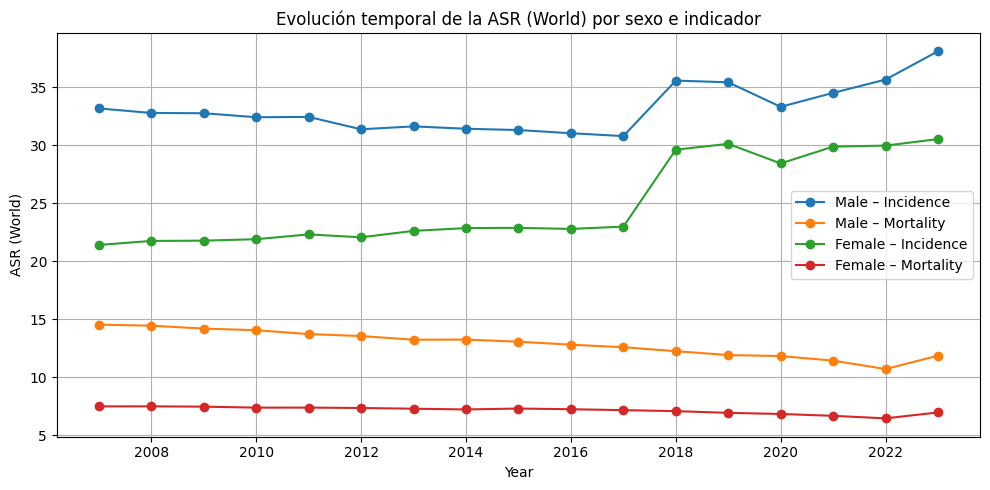

In [39]:
df_trend = (
    df_merged
    .dropna(subset=["Year", "ASR (World)", "Sex", "Type"])
    .groupby(["Year", "Sex", "Type"], as_index=False)
    .agg({"ASR (World)": "mean"})
    .sort_values("Year")
)

%matplotlib inline

plt.figure(figsize=(10,5))

for sex in ["Male", "Female"]:
    for t in ["Incidence", "Mortality"]:
        sub = df_trend[(df_trend["Sex"] == sex) & (df_trend["Type"] == t)]
        plt.plot(
            sub["Year"],
            sub["ASR (World)"],
            marker="o",
            label=f"{sex} – {t}"
        )

plt.xlabel("Year")
plt.ylabel("ASR (World)")
plt.title("Evolución temporal de la ASR (World) por sexo e indicador")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{fig_dir}/fig01_figure_ASR_anno.jpg", dpi=300, bbox_inches="tight")
plt.show()




En la serie temporal se observa un incremento aparente de las tasas a partir de 2017, que no debe interpretarse como un aumento abrupto de la incidencia real del cáncer. Este comportamiento coincide con actualizaciones metodológicas introducidas por GLOBOCAN, así como con mejoras en los sistemas de diagnóstico y registro en numerosos países, lo que puede generar discontinuidades en las series temporales.


El análisis principal se centró en la incidencia del cáncer, utilizando tasas estandarizadas por edad (ASR World), y se realizó de forma separada por sexo con el fin de preservar las diferencias epidemiológicas observadas entre hombres y mujeres.

A partir del análisis exploratorio visual, se podría seleccionar el  año 2022 como periodo de referencia, al tratarse del año más reciente y menos afectado por las distorsiones observadas durante la pandemia de COVID-19. Sin embargo, primeramente se debe ver si merece la pena usar ese año o usar otro.

Debido a la diferencia sistemática de los resultados por sexo, se realizarán los análisis por separado






In [40]:
idx = (
    df_merged
    .groupby(["Country_harmonized", "Sex", "Type"])["Year"]
    .idxmax()
)

df_latest = df_merged.loc[idx].reset_index(drop=True)


<Figure size 1000x500 with 0 Axes>

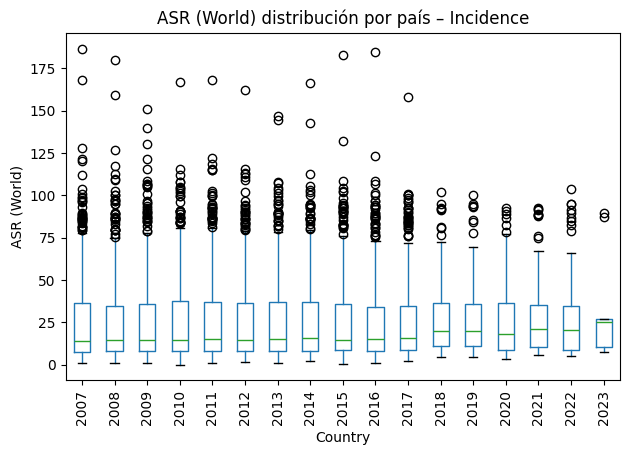

<Figure size 1000x500 with 0 Axes>

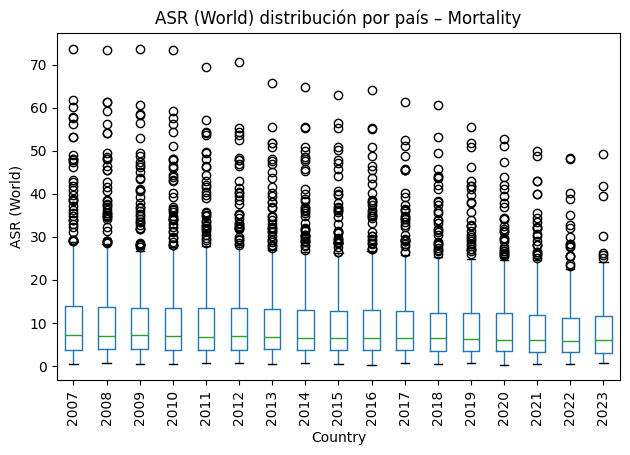

                count       mean        std       min        25%        50%  \
Type      Year                                                                
Incidence 2007  414.0  26.654503  28.009105  1.261740   7.712367  14.045255   
          2008  414.0  26.672272  27.808607  0.848776   7.866418  14.667344   
          2009  414.0  26.675268  27.504203  1.208534   7.802698  14.577169   
          2010  414.0  26.591915  26.910532  0.000000   8.071000  14.781473   
          2011  414.0  26.834266  27.402721  1.267041   8.114982  15.213739   
          2012  414.0  26.220596  26.448619  1.733681   7.828212  14.685083   
          2013  414.0  26.640309  26.651639  0.830335   8.192424  15.127576   
          2014  414.0  26.683246  26.418335  2.286980   8.273673  15.460607   
          2015  414.0  26.644043  26.774734  0.559190   8.456197  14.762662   
          2016  405.0  26.472491  26.808510  1.125282   8.278368  14.991421   
          2017  387.0  26.471117  26.211411  1.90925

In [41]:
df_plot = df_merged.copy()


for t in df_plot["Type"].unique():
    plt.figure(figsize=(10,5))

    df_plot[df_plot["Type"] == t].boxplot(
        column="ASR (World)",
        by="Year",
        grid=False,
        rot=90
    )

    plt.title(f"ASR (World) distribución por país – {t}")
    plt.suptitle("")
    plt.xlabel("Country")
    plt.ylabel("ASR (World)")
    plt.tight_layout()
    plt.savefig(f"{fig_dir}/fig02_boxplot_ASR_{t}.jpg", dpi=300, bbox_inches="tight")
    plt.show()

stats_simple = (
    df_plot
    .groupby(["Type", "Year"])["ASR (World)"]
    .describe()
)

print(stats_simple)



Estas figuras muestran la distribución de las tasas de incidencia y mortalidad estandarizadas por edad (ASR World) para el periodo 2007–2023 mediante diagramas de caja y bigotes. En ambos casos se observa una elevada heterogeneidad entre países, reflejada en amplios rangos intercuartílicos y la presencia sistemática de valores atípicos. La incidencia presenta una mayor dispersión que la mortalidad, lo que pone de manifiesto su mayor sensibilidad a factores como el diagnóstico precoz y la calidad de los registros. Por el contrario, la mortalidad muestra una distribución más estable y concentrada, lo que sugiere una mayor dependencia de la capacidad terapéutica de los sistemas sanitarios. Estas observaciones refuerzan la pertinencia de un análisis transversal por país y la utilización de la mortalidad como variable principal, complementada por la incidencia.

Para continuar con el análisis estadístico y valorar que año y paises utilizar en nuestro trabajo, se busca entonces valorar que paises tienen los datos de incidencia y/o mortalidad y tomar la decisión cual será la variable objetivo.



In [42]:
#cuantos paises hay con año, tipo de cancer y tipo

counts = (
    df_merged
    .groupby(
        ["Country_harmonized", "Year", "Cancer label", "Type"]
    )
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

 # cuantos países tienen los datos completos (both) o incompletos?

counts["both"] = (
    (counts.get("Incidence", 0) > 0) &
    (counts.get("Mortality", 0) > 0)
)

counts["only_incidence"] = (
    (counts.get("Incidence", 0) > 0) &
    (counts.get("Mortality", 0) == 0)
)

counts["only_mortality"] = (
    (counts.get("Incidence", 0) == 0) &
    (counts.get("Mortality", 0) > 0)
)

summary = {
    "Total combinaciones país–año–cáncer": len(counts),
    "Con incidencia y mortalidad": counts["both"].sum(),
    "Solo incidencia": counts["only_incidence"].sum(),
    "Solo mortalidad": counts["only_mortality"].sum(),
}
print(
    f"Total combinaciones país–año–cáncer: {summary['Total combinaciones país–año–cáncer']}\n"
    f"Con incidencia y mortalidad: {summary['Con incidencia y mortalidad']}\n"
    f"Solo incidencia: {summary['Solo incidencia']}\n"
    f"Solo mortalidad: {summary['Solo mortalidad']}"
)


#Un resumen por año

by_year = (
    counts
    .groupby("Year")[["both", "only_incidence", "only_mortality"]]
    .sum()
)

print(by_year)

#resumen por pais

by_country = (
    counts
    .groupby("Country_harmonized")[["both", "only_incidence", "only_mortality"]]
    .sum()
    .sort_values("both")
)

print(by_country.head(10))



Total combinaciones país–año–cáncer: 6438
Con incidencia y mortalidad: 2370
Solo incidencia: 798
Solo mortalidad: 3270
Type  both  only_incidence  only_mortality
Year                                      
2007   210              66             156
2008   210              66             156
2009   210              66             156
2010   210              66             156
2011   210              66             156
2012   210              66             156
2013   210              66             156
2014   210              66             156
2015   210              66             156
2016   204              66             162
2017   186              72             168
2018    18              12             336
2019    18              12             330
2020    18              12             300
2021    18              12             282
2022    18              12             210
2023     0               6              78
Type                both  only_incidence  only_mortality
Country

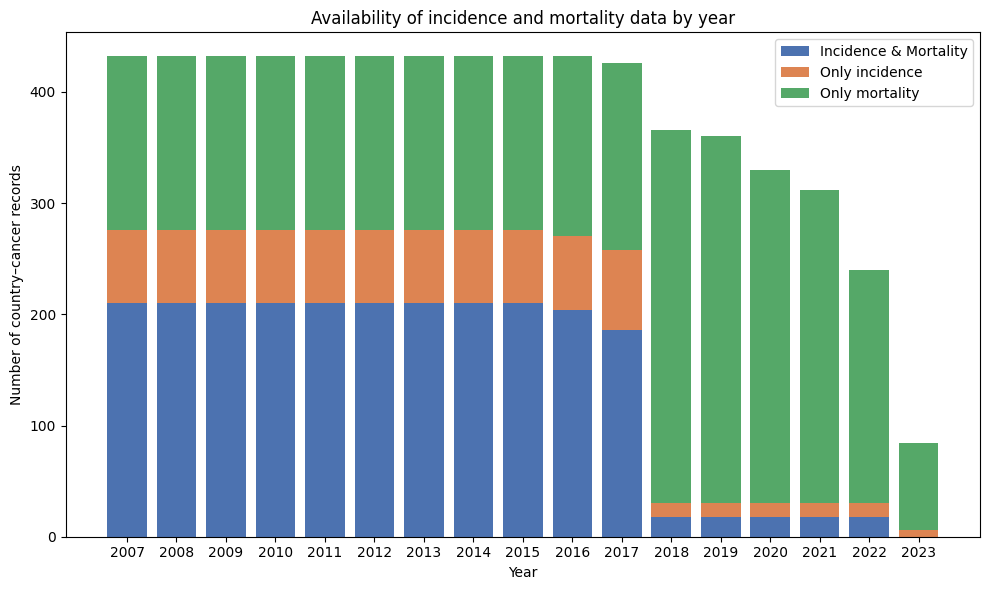

In [43]:
plt.figure(figsize=(10, 6))

plt.bar(
    by_year.index,
    by_year["both"],
    label="Incidence & Mortality",
    color="#4C72B0"
)

plt.bar(
    by_year.index,
    by_year["only_incidence"],
    bottom=by_year["both"],
    label="Only incidence",
    color="#DD8452"
)

plt.bar(
    by_year.index,
    by_year["only_mortality"],
    bottom=by_year["both"] + by_year["only_incidence"],
    label="Only mortality",
    color="#55A868"
)

plt.xlabel("Year")
plt.ylabel("Number of country–cancer records")
plt.title("Availability of incidence and mortality data by year")
plt.legend()
plt.tight_layout()
plt.xticks(by_year.index.astype(int))


plt.show()


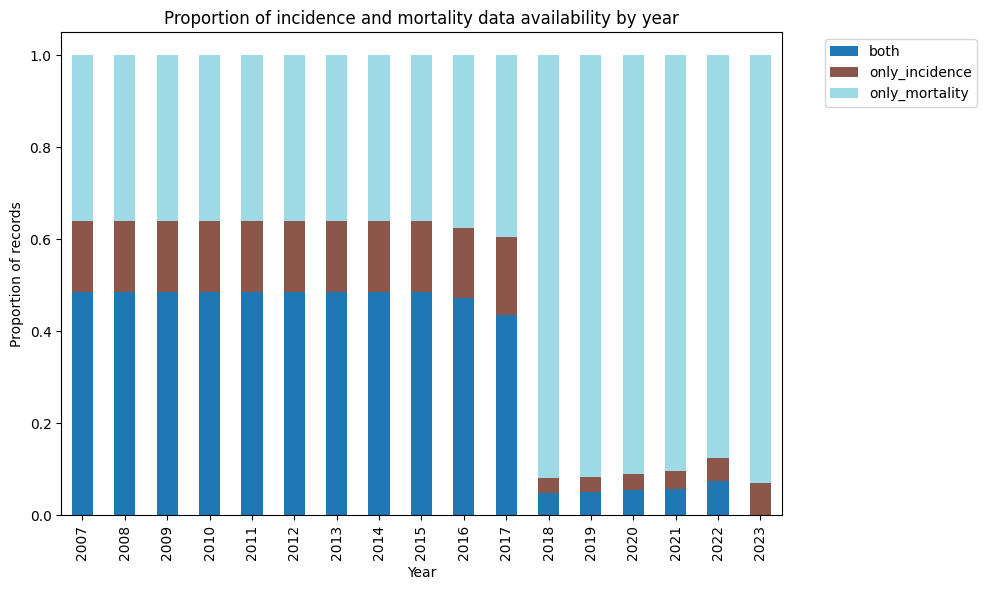

In [44]:
by_year_pct = by_year.div(by_year.sum(axis=1), axis=0)

by_year_pct.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6),
    colormap="tab20"
)

plt.xlabel("Year")
plt.ylabel("Proportion of records")
plt.title("Proportion of incidence and mortality data availability by year")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Claramente lo más conveniente es estudiar la mortalidad ya que se cuenta con una cantidad de datos estables a lo largo de los años, sin embargo, aprovechando que años anteriores al 2018 si existia un equilibro mas o menos entre datos de incidencia y mortalidad, se reliaza un pequeño estudio sobre sus relaciones.

Antes de integrar los datos de infraestructura, se realizó un análisis exploratorio de la disponibilidad de registros de incidencia y mortalidad por país, año y tipo de cáncer. Este análisis permitió identificar combinaciones incompletas y justificar la restricción posterior a observaciones con información simultánea de ambos indicadores. Para ver mejor los datos, se grafican para analizar si merece la pena continuar con datos donde aparezcan incidencia y mortalidad o dejamos solamente mortalidad.

Apartir de 2017, los datos de incidencia presentan una cobertura insuficiente y no homogénea entre países y cánceres, lo que compromete cualquier análisis comparativo robusto. Por el contrario, la mortalidad mantiene una cobertura amplia y consistente a lo largo del tiempo, convirtiéndose en la variable más fiable para el análisis global.

En base a la evolución temporal de la disponibilidad de datos, el análisis principal del estudio se centra en la mortalidad por cáncer, que presenta una cobertura amplia y consistente en todos los años analizados. La incidencia se utiliza únicamente de forma exploratoria en el periodo 2007–2016, donde la disponibilidad conjunta de ambos indicadores permite análisis comparativos robustos. A partir de 2017, la incidencia queda excluida del análisis principal debido a su escasa representatividad.

El análisis exploratorio de la cobertura geográfica por año mostró una estabilidad de datos incidencia y mortalidad elevada hasta 2016, seguida de una reducción progresiva en los años más recientes. Por este motivo, se busca además la cantidad de datos que se tienen por mortalidad compartiendo o no incidencia al mismo tiempo.
Esta estrategia permite evaluar la robustez de los resultados y analizar posibles cambios temporales sin comprometer la representatividad.

In [45]:
#Esto por ahora no aporta nada

df_mort_f = df_plot[(df_plot["Type"] == "Mortality") & (df_plot["Sex"] == "Female")]

top5_worst_f = (
    df_mort_f
    .sort_values(["Year", "ASR (World)"], ascending=[True, False])
    .groupby("Year")
    .head(5)
    .reset_index(drop=True)
)

print(top5_worst_f)


top5_best_f = (
    df_mort_f
    .sort_values(["Year", "ASR (World)"], ascending=[True, True])
    .groupby("Year")
    .head(5)
    .reset_index(drop=True)
)
print(top5_best_f)

df_mort_m = df_plot[(df_plot["Type"] == "Mortality") & (df_plot["Sex"] == "Male")]

top5_worst_m = (
    df_mort_m
    .sort_values(["Year", "ASR (World)"], ascending=[True, False])
    .groupby("Year")
    .head(5)
    .reset_index(drop=True)
)

print(top5_worst_m)


top5_best_m = (
    df_mort_m
    .sort_values(["Year", "ASR (World)"], ascending=[True, True])
    .groupby("Year")
    .head(5)
    .reset_index(drop=True)
)

print(top5_best_m)

   Cancer label     Sex       Type  Year  ASR (World)  Crude rate  \
0          Lung  Female  Mortality  2007    26.385216   56.332204   
1          Lung  Female  Mortality  2007    25.203079   48.857473   
2          Lung  Female  Mortality  2007    25.155698   48.642252   
3          Lung  Female  Mortality  2007    25.000663   46.484002   
4          Lung  Female  Mortality  2007    22.375917   50.541958   
..          ...     ...        ...   ...          ...         ...   
80         Lung  Female  Mortality  2023    25.794408   67.680431   
81       Breast  Female  Mortality  2023    20.610101   51.024802   
82       Breast  Female  Mortality  2023    20.376698   34.536431   
83         Lung  Female  Mortality  2023    20.029648   50.466351   
84       Breast  Female  Mortality  2023    16.483287   43.009822   

    Cumulative risk  Total        Country_harmonized  RTCenters With RT  \
0          3.243590   1553                   Denmark                  8   
1          2.996003  

In [46]:
# Ahora los extremos, mujer
summary_extremes_f = (
    df_mort_f
    .groupby("Year")
    .apply(lambda x: pd.DataFrame({
        "Worst_country": x.sort_values("ASR (World)", ascending=False)
                           .head(5)["Country_harmonized"].values,
        "Worst_cancer": x.sort_values("ASR (World)", ascending=False)
                          .head(5)["Cancer label"].values,
        "Worst_ASR": x.sort_values("ASR (World)", ascending=False)
                       .head(5)["ASR (World)"].values,
        "Best_country": x.sort_values("ASR (World)")
                          .head(5)["Country_harmonized"].values,
        "Best_cancer": x.sort_values("ASR (World)")
                         .head(5)["Cancer label"].values,
        "Best_ASR": x.sort_values("ASR (World)")
                      .head(5)["ASR (World)"].values
    }))
)


print(summary_extremes_f)

summary_extremes_m = (
    df_mort_m
    .groupby("Year")
    .apply(lambda x: pd.DataFrame({
        "Worst_country": x.sort_values("ASR (World)", ascending=False)
                           .head(5)["Country_harmonized"].values,
        "Worst_cancer": x.sort_values("ASR (World)", ascending=False)
                          .head(5)["Cancer label"].values,
        "Worst_ASR": x.sort_values("ASR (World)", ascending=False)
                       .head(5)["ASR (World)"].values,
        "Best_country": x.sort_values("ASR (World)")
                          .head(5)["Country_harmonized"].values,
        "Best_cancer": x.sort_values("ASR (World)")
                         .head(5)["Cancer label"].values,
        "Best_ASR": x.sort_values("ASR (World)")
                      .head(5)["ASR (World)"].values
    }))
)

print(summary_extremes_m)

                   Worst_country Worst_cancer  Worst_ASR    Best_country  \
Year                                                                       
2007 0                   Denmark         Lung  26.385216         Georgia   
     1                   Hungary         Lung  25.203079         Finland   
     2                    Canada         Lung  25.155698           Italy   
     3  United States of America         Lung  25.000663          Kuwait   
     4            United Kingdom         Lung  22.375917      Uzbekistan   
...                          ...          ...        ...             ...   
2023 0                   Hungary         Lung  25.794408          Kuwait   
     1                    Serbia       Breast  20.610101          Sweden   
     2                 Mauritius       Breast  20.376698         Austria   
     3                    Serbia         Lung  20.029648       Australia   
     4                   Hungary       Breast  16.483287  United Kingdom   

         Be

/tmp/ipython-input-3602018836.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.DataFrame({
/tmp/ipython-input-3602018836.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.DataFrame({


In [47]:
  #calcula las medias de mortalidd tanto de hombres como mujeres
mean_mort_m_by_year = (
    df_mort_m
    .groupby("Year")["ASR (World)"]
    .mean()
)


mean_mort_f_by_year = (
    df_mort_f
    .groupby("Year")["ASR (World)"]
    .mean()
)




#calculas los mejores paises con baja/alta mortalidad segun sexo

top5_best_16_22_m = (
    df_mort_m[df_mort_m["Year"].isin([2016, 2022])].copy()
    .sort_values("ASR (World)", ascending=True)
    .groupby("Year", group_keys=False)
    .head(5)
    .reset_index(drop=True)
)

top5_worst_16_22_m = (
    df_mort_m[df_mort_m["Year"].isin([2016, 2022])].copy()
    .sort_values("ASR (World)", ascending=False)
    .groupby("Year", group_keys=False)
    .head(5)
    .reset_index(drop=True)
)

top5_best_16_22_f = (
    df_mort_f[df_mort_f["Year"].isin([2016, 2022])].copy()
    .sort_values("ASR (World)", ascending=True)
    .groupby("Year", group_keys=False)
    .head(5)
    .reset_index(drop=True)
)

top5_worst_16_22_f = (
    df_mort_f[df_mort_f["Year"].isin([2016, 2022])].copy()
    .sort_values("ASR (World)", ascending=False)
    .groupby("Year", group_keys=False)
    .head(5)
    .reset_index(drop=True)
)



In [48]:
def plot_top5_by_sex_same_height(df_m, df_f, year, title_prefix, fig_dir=None, fname=None):


    # Ordenar ambos por severidad (de menor a mayor para que el peor quede arriba)
    df_m = df_m.sort_values("ASR (World)", ascending=True).reset_index(drop=True)
    df_f = df_f.sort_values("ASR (World)", ascending=True).reset_index(drop=True)


    # Etiquetas por sexo
    labels_m = df_m["Country_harmonized"] + " (" + df_m["Cancer label"] + ")"
    labels_f = df_f["Country_harmonized"] + " (" + df_f["Cancer label"] + ")"

    # Posiciones comunes
    y = np.arange(len(df_m))  # Top 5 → 0..4

    fig, ax = plt.subplots(figsize=(10, 6))

    # HOMBRES (izquierda)
    ax.barh(
        y,
        -df_m["ASR (World)"],
        color="#003f5c",
        height=0.6,
        label="Men"
    )

    # MUJERES (derecha)
    ax.barh(
        y,
        df_f["ASR (World)"],
        color="#F4A6C1",
        height=0.6,
        label="Women"
    )

    # Línea central
    ax.axvline(0, color="black", linewidth=1)
    #dibujar los verticales de las medias por sexo
      # Línea media hombres (izquierda, negativa)
    ax.axvline(
      -mean_mort_m_by_year.loc[year],
      color="#003f5c",
      linestyle="--",
      linewidth=2,
      alpha=0.8,
      label=f"Mean men: {mean_mort_m_by_year[year]:.2f}"
  )

# Línea media mujeres (derecha, positiva)
    ax.axvline(
      mean_mort_f_by_year.loc[year],
      color="#F4A6C1",
      linestyle="--",
      linewidth=2,
      alpha=0.8,
      label=f"Mean women: {mean_mort_f_by_year.loc[year]:.2f}"
  )


    # Eje Y izquierdo → hombres
    ax.set_yticks(y)
    ax.set_yticklabels(labels_m)

    # Eje Y derecho → mujeres
    ax_r = ax.twinx()
    ax_r.set_yticks(y)
    ax_r.set_yticklabels(labels_f)
    ax_r.set_ylim(ax.get_ylim())

    # Escalas y títulos
    max_val = max(
        df_m["ASR (World)"].max(),
        df_f["ASR (World)"].max()
    ) * 1.2

    ax.set_xlim(-max_val, max_val)
    ax.set_xlabel("Mortality ASR (World)")
    ax.set_title(f"{title_prefix} – {year} (Top 5 per sex)")
    ax.legend(loc="lower right")

    plt.tight_layout()
    if fig_dir and fname:
        plt.savefig(f"{fig_dir}/{fname}", dpi=300, bbox_inches="tight")
    plt.show()

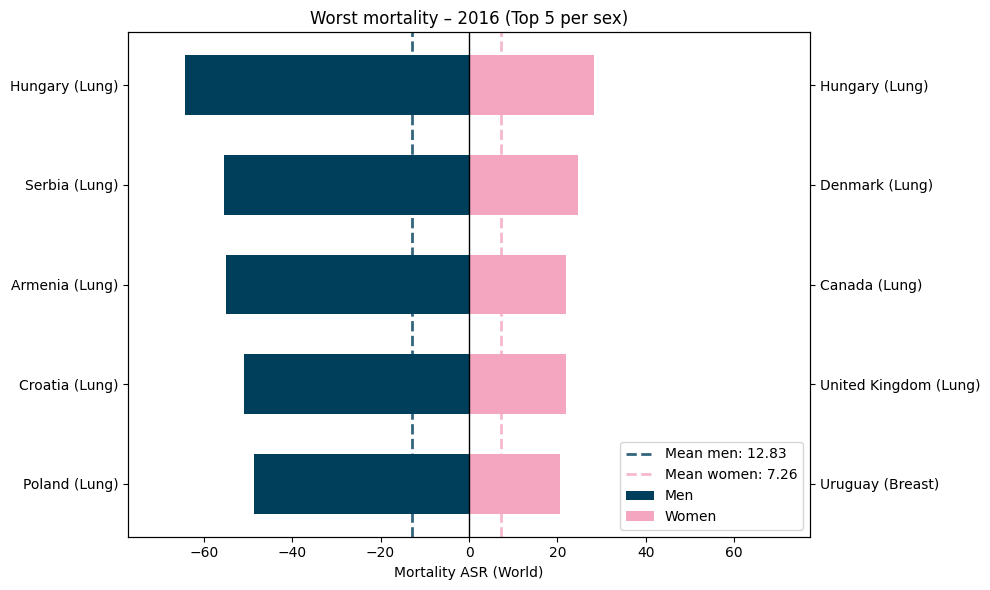

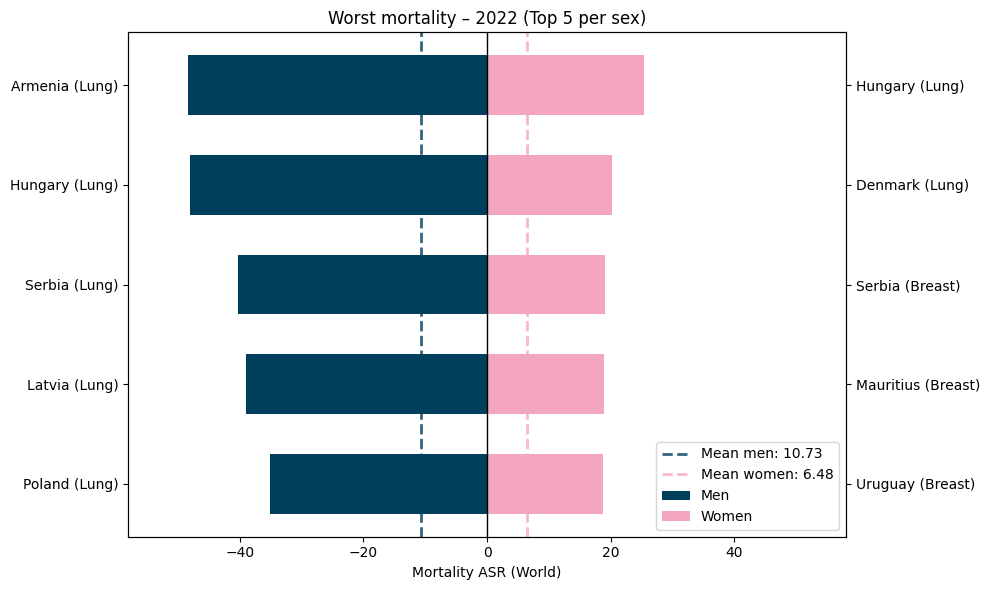

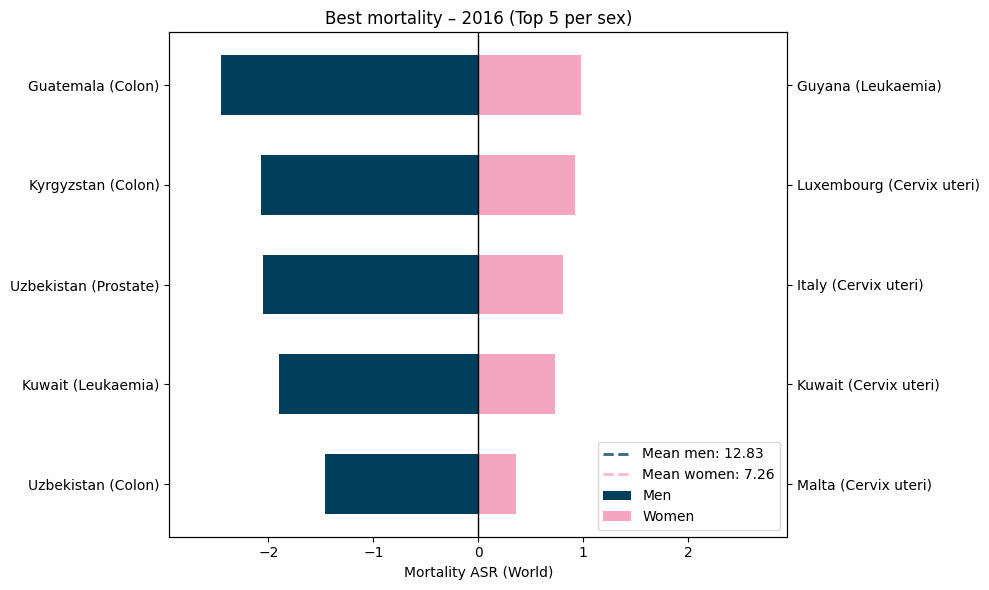

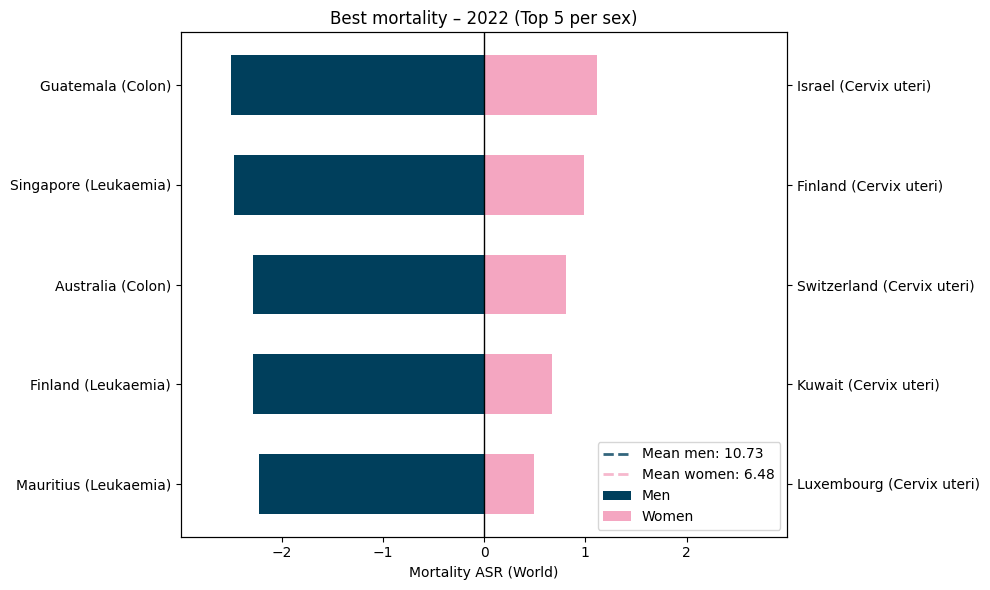

In [49]:
#Para los peores resultados en mortalidad

for year in [2016, 2022]:
    df_m = top5_worst_16_22_m[top5_worst_16_22_m["Year"] == year].head(5)
    df_f = top5_worst_16_22_f[top5_worst_16_22_f["Year"] == year].head(5)

    plot_top5_by_sex_same_height(
        df_m, df_f, year,
        title_prefix="Worst mortality",
        fig_dir=fig_dir,
        fname=f"worst_mortality_top5_by_sex_{year}.jpg"
    )

#par los mejores resultados en mortalidad
for year in [2016, 2022]:
    df_m = top5_best_16_22_m[top5_best_16_22_m["Year"] == year].head(5)
    df_f = top5_best_16_22_f[top5_best_16_22_f["Year"] == year].head(5)

    plot_top5_by_sex_same_height(
        df_m, df_f, year,
        title_prefix="Best mortality",
        fig_dir=fig_dir,
        fname=f"best_mortality_top5_by_sex_{year}.jpg"
    )



La mortalidad media se calculó de forma independiente para cada año y sexo, evitando mezclar periodos temporales con distinta cobertura y garantizando la comparabilidad entre 2016 y 2022.

Las líneas discontinuas representan la mortalidad media (ASR World) de los  países registrado para los años 2016 y 2022. Se observa que la mortalidad media masculina es sistemáticamente superior a la femenina, tanto en magnitud como en dispersión, lo que refuerza la necesidad de realizar análisis estratificados por sexo.

Para saber hasta donde llegan nuestro alcance con los datos si se consideran tanto incidencia como mortalidad, graficamos el número de países registrados por año

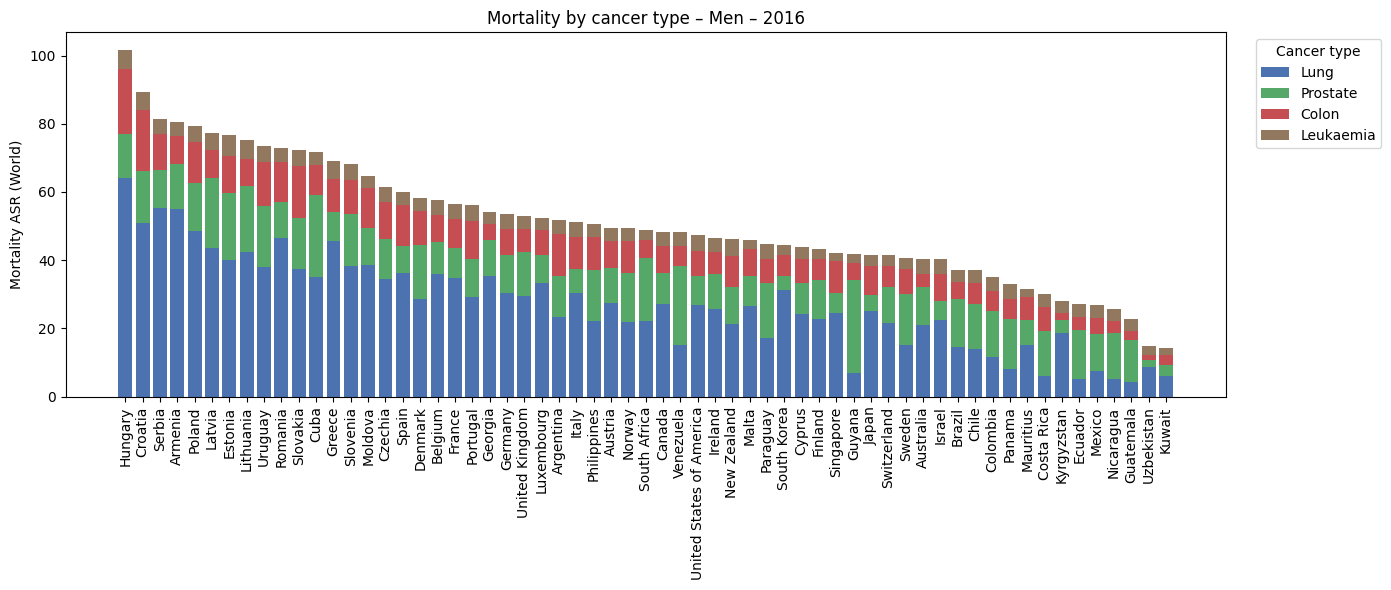

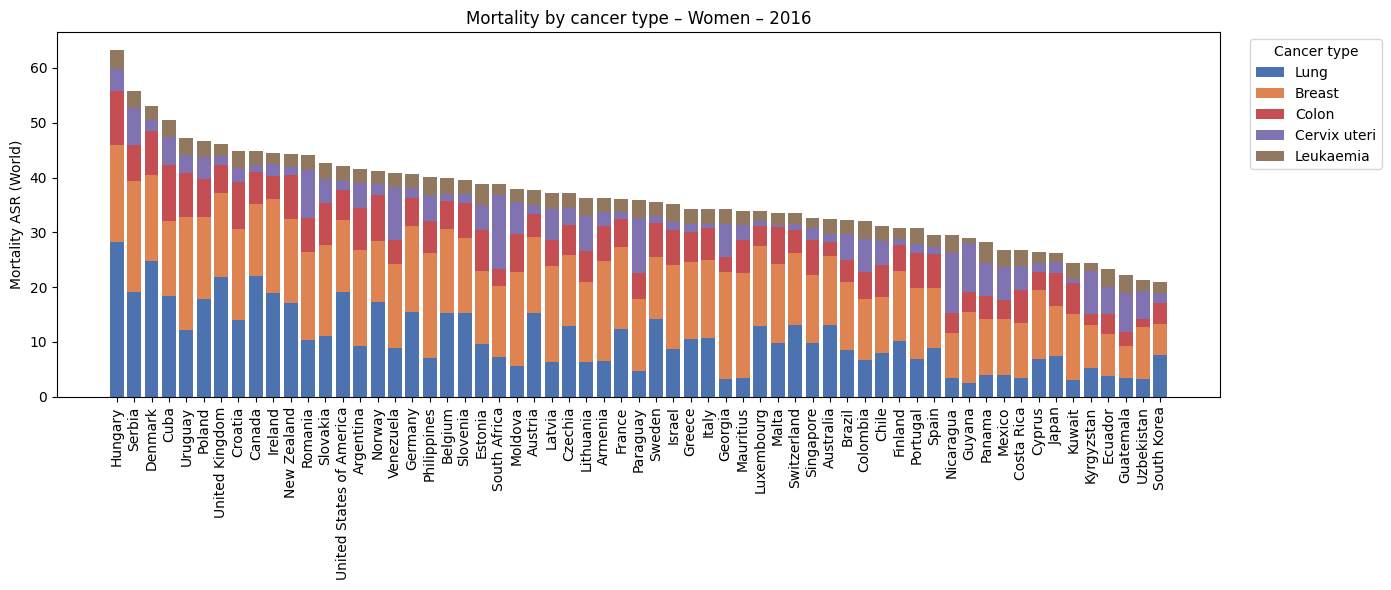

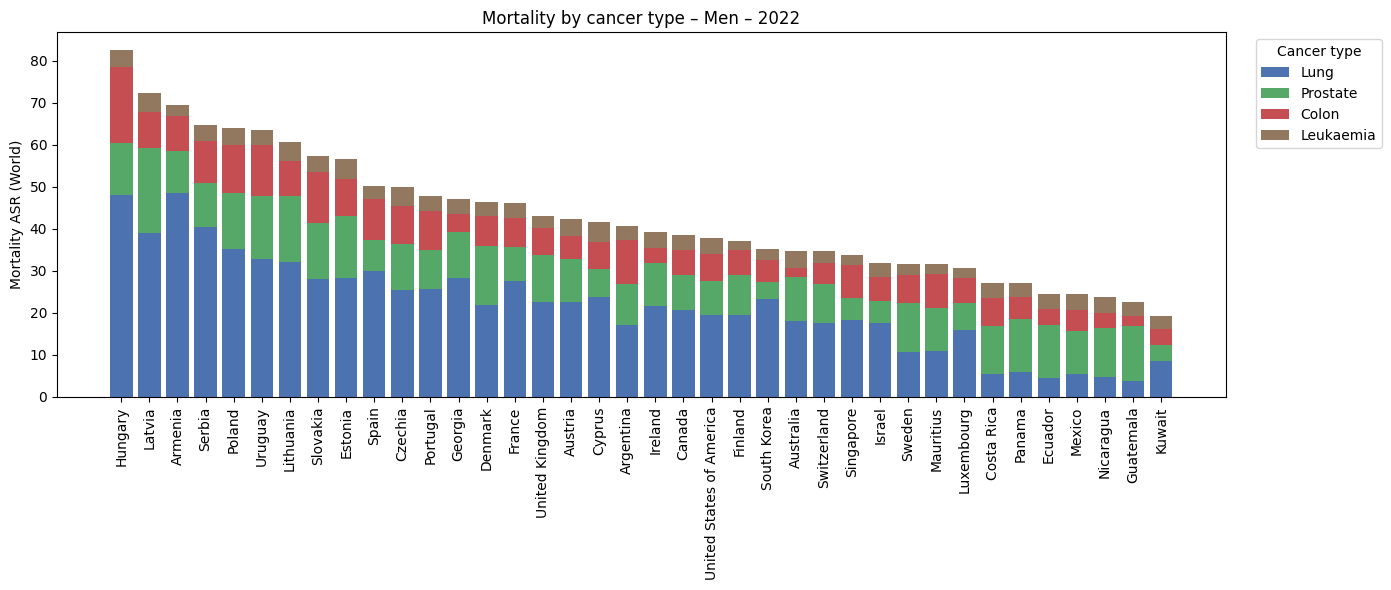

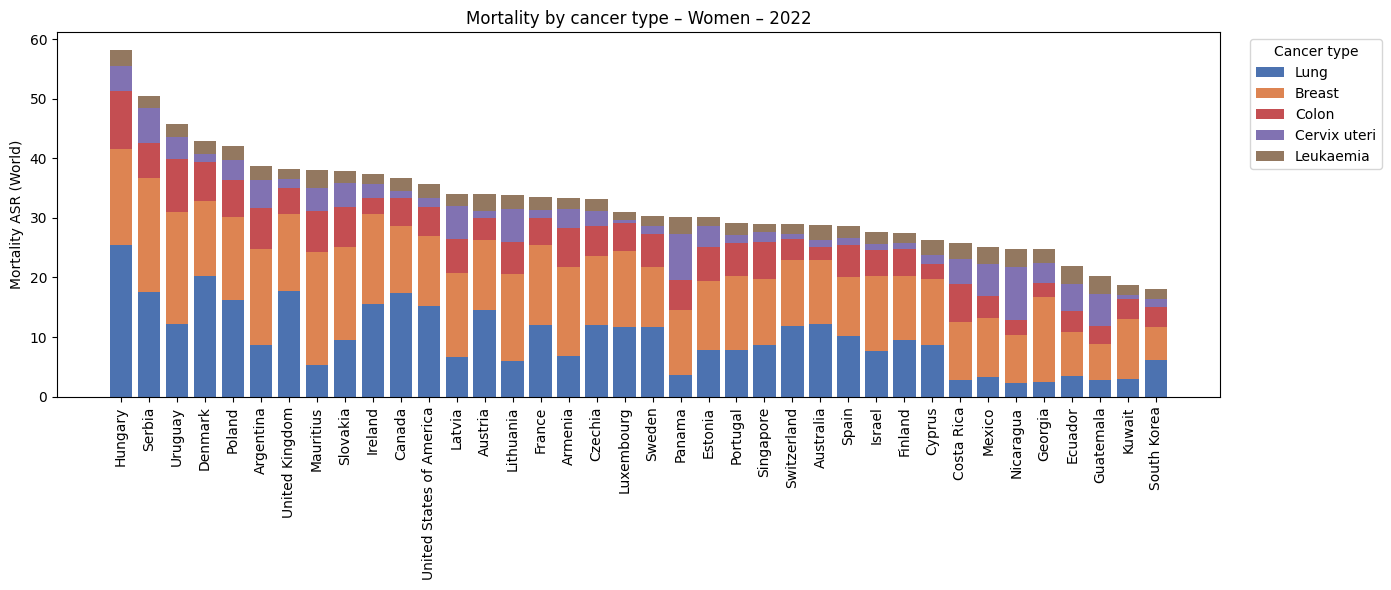

In [50]:
#cada tipo de cancer, un color distinto

cancer_colors = {
    "Lung": "#4C72B0",        # azul
    "Breast": "#DD8452",      # naranja
    "Prostate": "#55A868",    # verde
    "Colon": "#C44E52",       # rojo
    "Cervix uteri": "#8172B2",# morado
    "Leukaemia": "#937860"    # marrón
}

#Preparar por año y sexo la mortalidad para agrupar por pais y tipo de cancer
def prepare_stacked_mortality_by_sex(df, year, sex):
    df_y = df[
        (df["Year"] == year) &
        (df["Type"] == "Mortality") &
        (df["Sex"] == sex)
    ].copy()

    agg = (
        df_y
        .groupby(["Country_harmonized", "Cancer label"], as_index=False)
        .agg({"ASR (World)": "mean"})
    )

    return agg


def pivot_stacked(df_agg):
    pivot = df_agg.pivot(
        index="Country_harmonized",
        columns="Cancer label",
        values="ASR (World)"
    ).fillna(0)

    return pivot

#función para graficar las barras por país la mortalidad
def plot_stacked_mortality_by_sex(pivot, year, sex_label, fig_dir=None):
    plt.figure(figsize=(14, 6))

    bottom = np.zeros(len(pivot))

    for cancer in pivot.columns:
        plt.bar(
            pivot.index,
            pivot[cancer],
            bottom=bottom,
            label=cancer,
            color=cancer_colors[cancer] # Use cancer to get color dynamically
        )
        bottom += pivot[cancer].values

    plt.xticks(rotation=90)
    plt.ylabel("Mortality ASR (World)")
    plt.title(f"Mortality by cancer type – {sex_label} – {year}")
    plt.legend(title="Cancer type", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()

    if fig_dir:
        plt.savefig(
            f"{fig_dir}/stacked_mortality_{sex_label}_{year}.jpg",
            dpi=300,
            bbox_inches="tight"
        )

    plt.show()



# 2016

#Para hombres
mort_2016_m = prepare_stacked_mortality_by_sex(df_merged, 2016, "Male")



pivot_2016_m_full = pivot_stacked(mort_2016_m)
existing_cancer_keys_m = [key for key in cancer_colors.keys() if key in pivot_2016_m_full.columns]
pivot_2016_m = pivot_2016_m_full[existing_cancer_keys_m]

pivot_2016_m = pivot_2016_m.loc[
    pivot_2016_m.sum(axis=1).sort_values(ascending=False).index
]

#para mujeres
mort_2016_f = prepare_stacked_mortality_by_sex(df_merged, 2016, "Female")
pivot_2016_f_full = pivot_stacked(mort_2016_f)
existing_cancer_keys_f = [key for key in cancer_colors.keys() if key in pivot_2016_f_full.columns]
pivot_2016_f = pivot_2016_f_full[existing_cancer_keys_f]

pivot_2016_f = pivot_2016_f.loc[
    pivot_2016_f.sum(axis=1).sort_values(ascending=False).index
]


plot_stacked_mortality_by_sex(
    pivot_2016_m,
    2016,
    "Men",
    fig_dir
)

plot_stacked_mortality_by_sex(
    pivot_2016_f,
    2016,
    "Women",
    fig_dir
)

# 2022
#graficar para hombres
mort_2022_m = prepare_stacked_mortality_by_sex(df_merged, 2022, "Male")

pivot_2022_m_full = pivot_stacked(mort_2022_m)
existing_cancer_keys_m_2022 = [key for key in cancer_colors.keys() if key in pivot_2022_m_full.columns]
pivot_2022_m = pivot_2022_m_full[existing_cancer_keys_m_2022]

pivot_2022_m = pivot_2022_m.loc[
    pivot_2022_m.sum(axis=1).sort_values(ascending=False).index
]

#graficar Para mujeres
mort_2022_f = prepare_stacked_mortality_by_sex(df_merged, 2022, "Female")
pivot_2022_f_full = pivot_stacked(mort_2022_f)
existing_cancer_keys_f_2022 = [key for key in cancer_colors.keys() if key in pivot_2022_f_full.columns]
pivot_2022_f = pivot_2022_f_full[existing_cancer_keys_f_2022]

pivot_2022_f = pivot_2022_f.loc[
    pivot_2022_f.sum(axis=1).sort_values(ascending=False).index
]


plot_stacked_mortality_by_sex(
    pivot_2022_m,
    2022,
    "Men",
    fig_dir
)

plot_stacked_mortality_by_sex(
    pivot_2022_f,
    2022,
    "Women",
    fig_dir
)

In [51]:
df_merged.head()

,Cancer label,Sex,Type,Year,ASR (World),Crude rate,Cumulative risk,Total,Country_harmonized,RTCenters With RT,He Photon And Electron Beam Rt,Proton Ion Therapy,XRay Generator,Brachy Therapy Inc El,Last Update,Population,Population_male,Population_female
0,Lung,Male,Incidence,2007,61.434111,80.958928,7.865065,3666,Belarus,13,31,0,11,17,2024,9563133.0,4450421.0,5112713.0
1,Lung,Male,Incidence,2008,62.729974,84.930604,8.033257,3765,Belarus,13,31,0,11,17,2024,9529358.0,4432534.0,5096824.0
2,Lung,Male,Incidence,2009,61.098990,84.106229,7.731976,3719,Belarus,13,31,0,11,17,2024,9507337.0,4421224.0,5086114.0
3,Lung,Male,Incidence,2010,62.582334,86.376743,7.914747,3812,Belarus,13,31,0,11,17,2024,9490752.0,4412608.0,5078144.0
4,Lung,Male,Incidence,2011,59.755001,83.234410,7.621488,3665,Belarus,13,31,0,11,17,2024,9472735.0,4402539.0,5070196.0


In [52]:
df_2016 = df_merged[df_merged["Year"] == 2016]
df_2022 = df_merged[df_merged["Year"] == 2022]

print("El numero de paises registrados en el 2016:", df_2016["Country_harmonized"].nunique())
print("El número de países registrados en el 2022:" , df_2022["Country_harmonized"].nunique())


El numero de paises registrados en el 2016: 72
El número de países registrados en el 2022: 40


Para poder continuar con el análisis, es importante asegurarse de que exista en cada fila incidencias y mortalidad para poder así graficarlo correctamente, por lo tanto, lo primero que se hará es limpiar esta información, para evitar estos valores perdidos, se guardarán solamente los que tengan ambos

In [53]:
complete_keys = (
    df_merged
    .groupby(["Country_harmonized", "Year", "Sex"])["Type"]
    .nunique()
    .reset_index()
    .query("Type == 2")
)


df_complete = df_merged.merge(
    complete_keys[["Country_harmonized", "Year", "Sex"]],
    on=["Country_harmonized", "Year", "Sex"],
    how="inner"
)
#Ahora solo contiene observaciones donde existen ambos tipos.

def build_pivot(df):
    df_scatter = (
        df
        .groupby(
            ["Country_harmonized", "Year", "Type"],
            as_index=False
        )
        .agg({"ASR (World)": "mean"})
    )

    pivot = (
        df_scatter
        .pivot_table(
            index=["Country_harmonized", "Year"],
            columns="Type",
            values="ASR (World)"
        )
        .reset_index()
    )

    return pivot

pivot_male = build_pivot(df_male)
pivot_female = build_pivot(df_female)
pivot_all = build_pivot(df_complete)

pivot_male_clean = pivot_male.dropna(subset=["Incidence", "Mortality"])
pivot_female_clean = pivot_female.dropna(subset=["Incidence", "Mortality"])


print("Male:", pivot_male_clean.shape)
print("Female:", pivot_female_clean.shape)

print(
    "Male - países:",
    pivot_male_clean["Country_harmonized"].nunique()
)

print(
    "Female - países:",
    pivot_female_clean["Country_harmonized"].nunique()
)


Male: (395, 4)
Female: (395, 4)
Male - países: 35
Female - países: 35


El análisis de la relación entre incidencia y mortalidad se restringió a aquellas combinaciones país–año–sexo con información disponible para ambos indicadores. Esta restricción reduce el tamaño muestral, pero garantiza la coherencia del análisis bivariado, evitando inferencias basadas en información incompleta.

Haciendo un bozquejo de lo que se ha estado encontrando, se ve claramente que la mortalidad de hombres en algunos países hasta casi dobla en números con respecto a mujeres, habrá que ver por tipo de cáncer (los que afectan exclusivamente a hombres y los que afectan a las mujeres) ocasiona esta disparidad.

Los datos se transformaron a formato ancho mediante una tabla pivote, separando explícitamente la incidencia y la mortalidad en columnas independientes para cada combinación de país, año y sexo, lo que permitió el hint: análisis de su relación mediante correlación y regresión.


Ahora se puede calcular tanto la correlación de Pearson como, la pendiente de la curva, en el caso de ver claramente una tendencia.

In [54]:
def compute_beta_R(df):
    x = df["Incidence"].values
    y = df["Mortality"].values

    beta, alpha = np.polyfit(x, y, 1)
    R = np.corrcoef(x, y)[0, 1]

    return beta, alpha, R

beta_f, alpha_f, R_f = compute_beta_R(pivot_female_clean)
beta_m,  alpha_m,  R_m  = compute_beta_R(pivot_male_clean)
beta_all, alpha_all, R_all = compute_beta_R(pivot_all)

print(f"Female  -> beta={beta_f:.3f}, alpha={alpha_f:.3f}, R={R_f:.3f}, N={len(pivot_female_clean)}")
print(pivot_female_clean.head())

print(f"Male    -> beta={beta_m:.3f},  alpha={alpha_m:.3f},  R={R_m:.3f},  N={len(pivot_male_clean)}")
print(pivot_male_clean.head())

print(f"All    -> beta={beta_all:.3f},  alpha={alpha_all:.3f},  R={R_all:.3f},  N={len(pivot_all)}")
print(pivot_all.head())

Female  -> beta=0.184, alpha=3.073, R=0.609, N=395
Type Country_harmonized  Year  Incidence  Mortality
0             Argentina  2007  21.105817   8.274651
1             Argentina  2008  24.109715   8.117734
2             Argentina  2009  22.862996   8.199053
3             Argentina  2010  22.665475   8.070498
4             Argentina  2011  22.181812   7.995091
Male    -> beta=0.259,  alpha=4.947,  R=0.596,  N=395
Type Country_harmonized  Year  Incidence  Mortality
0             Argentina  2007  22.999171  15.479395
1             Argentina  2008  21.814043  15.000062
2             Argentina  2009  24.982291  14.555391
3             Argentina  2010  22.635477  14.400345
4             Argentina  2011  23.059037  14.122212
All    -> beta=0.207,  alpha=4.393,  R=0.547,  N=395
Type Country_harmonized  Year  Incidence  Mortality
0             Argentina  2007  21.947307  11.476759
1             Argentina  2008  23.089416  11.176546
2             Argentina  2009  23.804905  11.024092
3         

Tras la estratificación por sexo y la exigencia de disponibilidad simultánea de datos de incidencia y mortalidad, el análisis se restringe a un subconjunto de 36 países. Este subconjunto es común a hombres y mujeres, lo que permite realizar comparaciones directas entre sexos sin introducir sesgos derivados de diferencias en la cobertura geográfica.

La relación entre incidencia y mortalidad es más pronunciada en hombres que en mujeres, mientras que en mujeres la relación es más consistente y menos dispersa. El análisis agregado por sexo reduce la calidad del ajuste y oculta estas diferencias, lo que justifica plenamente la estratificación por sexo en los análisis posteriores.


Al estratificar el análisis por sexo, se observan diferencias claras en la relación entre incidencia y mortalidad. En hombres, la pendiente del modelo es mayor, lo que indica un incremento más acusado de la mortalidad a medida que aumenta la incidencia. En mujeres, la relación es menos pronunciada pero más consistente, reflejada en un coeficiente de correlación superior. Por el contrario, el análisis agregado por sexo presenta una menor capacidad explicativa, lo que evidencia que la agregación de ambos sexos introduce heterogeneidad y enmascara patrones relevantes





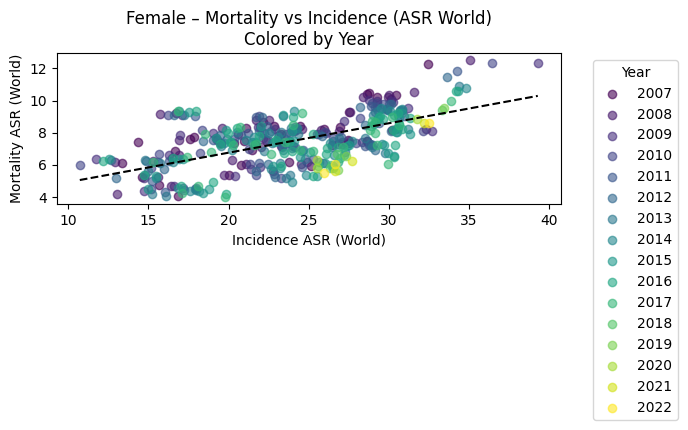

In [55]:
# cálculo de la recta en mujeres
plt.figure(figsize=(7, 7))

years = sorted(pivot_female_clean["Year"].unique())
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(years)))

for y, c in zip(years, colors):
    df_y = pivot_female_clean[pivot_female_clean["Year"] == y]

    plt.scatter(
        df_y["Incidence"],
        df_y["Mortality"],
        alpha=0.6,
        color=c,
        label=str(y)
    )

# Recta global (
x_f = pivot_female_clean["Incidence"].values
y_f = pivot_female_clean["Mortality"].values
beta_f, alpha_f = np.polyfit(x_f, y_f, 1)

x_line = np.linspace(x_f.min(), x_f.max(), 200)
plt.plot(x_line, beta_f * x_line + alpha_f, linestyle="--", color="black")

plt.xlabel("Incidence ASR (World)")
plt.ylabel("Mortality ASR (World)")
plt.title("Female – Mortality vs Incidence (ASR World)\nColored by Year")

plt.legend(
    title="Year",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.gca().set_aspect("equal", adjustable="box")
plt.grid(False)
plt.tight_layout()
plt.show()



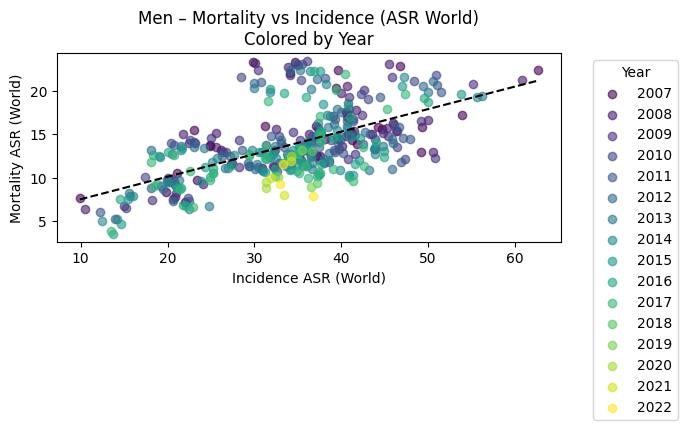

In [56]:
#hombres
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7, 7))

years = sorted(pivot_male_clean["Year"].unique())
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(years)))

for y, c in zip(years, colors):
    df_y = pivot_male_clean[pivot_male_clean["Year"] == y]

    plt.scatter(
        df_y["Incidence"],
        df_y["Mortality"],
        alpha=0.6,
        color=c,
        label=str(y)
    )

# Recta global
x_m = pivot_male_clean["Incidence"].values
y_m = pivot_male_clean["Mortality"].values
beta_m, alpha_m = np.polyfit(x_m, y_m, 1)

x_line = np.linspace(x_m.min(), x_m.max(), 200)
plt.plot(x_line, beta_m * x_line + alpha_m, linestyle="--", color="black")

plt.xlabel("Incidence ASR (World)")
plt.ylabel("Mortality ASR (World)")
plt.title("Men – Mortality vs Incidence (ASR World)\nColored by Year")

plt.legend(
    title="Year",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.gca().set_aspect("equal", adjustable="box")
plt.grid(False)
plt.tight_layout()
plt.show()



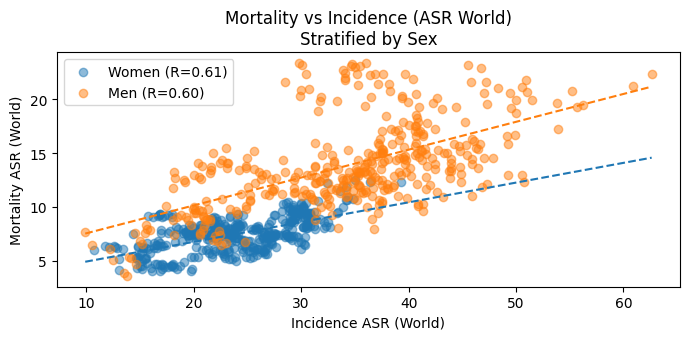

In [57]:
plt.figure(figsize=(7, 7))

plt.scatter(
    x_f, y_f,
    alpha=0.5,
    label=f"Women (R={R_f:.2f})"
)

plt.scatter(
    x_m, y_m,
    alpha=0.5,
    label=f"Men (R={R_m:.2f})"
)

# rectas
x_min = min(x_f.min(), x_m.min())
x_max = max(x_f.max(), x_m.max())
x_line = np.linspace(x_min, x_max, 200)

plt.plot(x_line, beta_f * x_line + alpha_f, linestyle="--")
plt.plot(x_line, beta_m * x_line + alpha_m, linestyle="--")

plt.xlabel("Incidence ASR (World)")
plt.ylabel("Mortality ASR (World)")
plt.title("Mortality vs Incidence (ASR World)\nStratified by Sex")

plt.legend()
plt.gca().set_aspect("equal", adjustable="box")
plt.grid(False)
plt.tight_layout()
plt.show()


Las representaciones gráficas de incidencia frente a mortalidad muestran patrones claramente diferenciados por sexo. En hombres, la pendiente es mayor y la dispersión más elevada, lo que indica un aumento más acusado de la mortalidad con la incidencia. En mujeres, la relación es más moderada y consistente, la mortalidad crece más lentamente con la incidencia. La superposición de ambos sexos evidencia que el análisis agregado oculta estas diferencias estructurales, justificando la estratificación por sexo adoptada en este estudio.

La mayor pendiente y correlación observadas en hombres sugieren una relación más fuerte entre incidencia y mortalidad, lo que podría estar relacionado con diferencias en tipos de cáncer predominantes, factores de riesgo y acceso al diagnóstico precoz.



In [58]:
#Creación de tabla
male_tab = pivot_male_clean.copy()
male_tab["Sex"] = "Male"

female_tab = pivot_female_clean.copy()
female_tab["Sex"] = "Female"

#unirlas
tab_sex = pd.concat([male_tab, female_tab], ignore_index=True)

#reunir por año y sexo
table_year_sex = (
    tab_sex
    .groupby(["Year", "Sex"], as_index=False)
    .agg({
        "Incidence": "mean",
        "Mortality": "mean"
    })
)

table_year_sex


table_year_sex_n = (
    tab_sex
    .groupby(["Year", "Sex"])
    .agg(
        Incidence_mean=("Incidence", "mean"),
        Mortality_mean=("Mortality", "mean"),
        N_countries=("Country_harmonized", "nunique")
    )
    .reset_index()
)

table_year_sex_n



table_wide = table_year_sex_n.pivot(
    index="Year",
    columns="Sex",
    values=["Incidence_mean", "Mortality_mean", "N_countries"]
)

table_wide



Incidence_mean            Mortality_mean            N_countries      
Sex          Female       Male         Female       Male      Female  Male
Year                                                                      
2007      22.957069  35.719077       7.785539  15.319651        35.0  35.0
2008      23.230595  35.213016       7.744246  15.106716        35.0  35.0
2009      23.257645  35.619436       7.669180  14.703307        35.0  35.0
2010      23.449095  34.785683       7.627605  14.557902        35.0  35.0
2011      23.827802  34.939991       7.547607  14.216407        35.0  35.0
2012      23.424347  33.454656       7.508182  13.963847        35.0  35.0
2013      24.042726  33.814635       7.345541  13.530861        35.0  35.0
2014      24.316393  33.267302       7.251474  13.329339        35.0  35.0
2015      24.294356  33.152564       7.262936  13.059781        35.0  35.0
2016      24.202656  32.920748       7.307731  12.744160        34.0  34.0
2017      24.080175  32.578674       7.249940  12.659498        31.0  31.0
2018      28.775624  35.381639       7.296816  10.933713         3.0   3.0
2019      29.189614  34.897561       7.253780  10.733314         3.0   3.0
2020      27.608674  32.284985       6.967152  10.281527         3.0   3.0
2021      28.833261  33.174032       6.824616   9.993179         3.0   3.0
2022      28.345842  34.331277       6.710525   9.582967         3.0   3.0

Esta tabla muestran los paises que tienen tanto mortalidad como incidencia simultaneamente. Se puede ver que el diagnostico en mujeres ha aumentado mientras que en hombres permanece mas o menos igual. Las muertes han disminuidos para ambos sexos pero se ve claramente que en hombres, el índice es superior.

Los períodos más robustos están desde el 2007 hasta el 2017.

Dado que los niveles absolutos de incidencia y mortalidad difieren sustancialmente entre sexos, el uso de valores agregados ocultaría patrones epidemiológicos relevantes y sesgaría la interpretación de la relación incidencia–mortalidad.




Justificación del uso de la mortalidad como variable de resultado (2016–2022)

Con el objetivo de garantizar la comparabilidad temporal y maximizar la cobertura geográfica del análisis, se evaluó la disponibilidad de datos de incidencia y mortalidad para los años 2016 y 2022, que constituyen los dos puntos temporales de referencia en este estudio.

El año 2016 representa el último periodo en el que una proporción sustancial de países dispone simultáneamente de datos de incidencia y mortalidad, permitiendo una caracterización relativamente completa de ambos indicadores. Sin embargo, en 2022 se observa un cambio estructural muy marcado en la disponibilidad de los datos: la mayoría de los registros país–cáncer corresponden exclusivamente a mortalidad, mientras que los datos de incidencia están disponibles únicamente para un número reducido de países.

Este contraste implica que el uso de la incidencia, o de modelos que requieran simultáneamente incidencia y mortalidad, conduciría en 2022 a una reducción drástica del tamaño muestral y a un sesgo hacia países con sistemas de registro oncológico más desarrollados. En cambio, la mortalidad mantiene una cobertura geográfica amplia y homogénea en ambos años, permitiendo una comparación consistente entre países y a lo largo del tiempo.

Dado que el objetivo del trabajo es analizar la relación entre los resultados en cáncer y la disponibilidad de infraestructuras de radioterapia, se selecciona la mortalidad como variable principal de resultado para los análisis comparativos entre 2016 y 2022. Esta elección permite maximizar el número de países incluidos, garantizar la coherencia temporal del análisis y centrarse en un desenlace clínico final estrechamente vinculado al acceso y la efectividad de los tratamientos oncológicos.

###Conexión directa con lo que viene (DIRAC)

A partir de esta evaluación, los análisis posteriores se centran exclusivamente en la mortalidad por cáncer, que se relaciona con la disponibilidad de infraestructura de radioterapia (DIRAC) y se ajusta por población.

Ahora, se construye el primer scatter con indice de mortalidad vs centros de radioterapia existentes. Para esto, es necesario normalizar la infraestructura por población, es decir, RT centers y equipos por millón de habitantes.

In [67]:
df_merged_all = df_merged.copy()
df_merged_all = df_merged_all[df_merged_all["Type"] == "Mortality"].copy()
df_merged_all = (
    df_merged_all[
        df_merged_all["Year"].isin([2016, 2022])
    ]
    .copy()
)
df_merged_all = df_merged_all[
    df_merged_all["Cancer label"] != "Leukaemia"
].copy()

df_merged_all["Year"].value_counts().sort_index()



,count
Year,
2016,427
2022,266


La leucemia se excluye del análisis dado que su manejo clínico no depende principalmente de infraestructuras de radioterapia, sino de tratamientos sistémicos como quimioterapia y terapias dirigidas. Su inclusión podría introducir ruido y sesgos en el estudio de la relación entre mortalidad y disponibilidad de radioterapia.

In [68]:


#variables a calcular por millón de habitantes de los paises correspondientes
rt_vars = [
    "RTCenters With RT",
    "He Photon And Electron Beam Rt",
    "Proton Ion Therapy",
    "XRay Generator",
    "Brachy Therapy Inc El"
]

rt_vars_pm = [f"{v}_million" for v in rt_vars]
#función
def prepare_rt_centers_per_million(df,variable):
    df[f"{variable}_million"] = df[variable]/df["Population"]*1_000_000
    return df

for var in rt_vars:
    df_merged_all = prepare_rt_centers_per_million(
        df_merged_all,
        var
    )




In [69]:
df_merged_all.head()

,Cancer label,Sex,Type,Year,ASR (World),Crude rate,Cumulative risk,Total,Country_harmonized,RTCenters With RT,...,Brachy Therapy Inc El,Last Update,Population,Population_male,Population_female,RTCenters With RT_million,He Photon And Electron Beam Rt_million,Proton Ion Therapy_million,XRay Generator_million,Brachy Therapy Inc El_million
42,Lung,Male,Mortality,2016,27.122063,58.122336,3.095859,10481,Canada,52,...,52,2025,36353343.0,18032655.0,18320689.0,1.430405,8.142305,0.0,0.385109,1.430405
48,Lung,Male,Mortality,2022,20.689747,50.979249,2.350679,9830,Canada,52,...,52,2025,38821259.0,19282356.0,19538904.0,1.339472,7.624688,0.0,0.360627,1.339472
69,Lung,Female,Mortality,2016,22.005901,52.345194,2.648721,9590,Canada,52,...,52,2025,36353343.0,18032655.0,18320689.0,1.430405,8.142305,0.0,0.385109,1.430405
75,Lung,Female,Mortality,2022,17.433952,47.704826,2.065611,9321,Canada,52,...,52,2025,38821259.0,19282356.0,19538904.0,1.339472,7.624688,0.0,0.360627,1.339472
96,Lung,Male,Mortality,2016,14.024196,20.636850,1.770362,1875,Chile,24,...,8,2025,18267221.0,9085689.0,9181532.0,1.313829,2.463429,0.0,0.000000,0.437943


In [72]:
def scatter_mortality_vs_rt(df, rt_var_pm, years=[2016, 2022]):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    for ax, year in zip(axes, years):
        df_y = df[df["Year"] == year]

        ax.scatter(
            df_y[rt_var_pm],
            df_y["ASR (World)"],
            alpha=0.7
        )

        ax.set_title(str(year))
        ax.set_xlabel(f"{rt_var_pm.replace('_per_million', '')}\n(per million inhabitants)")

    axes[0].set_ylabel("Mortality ASR (World)")
    plt.suptitle("Cancer mortality vs radiotherapy availability")
    plt.tight_layout()
    plt.show()



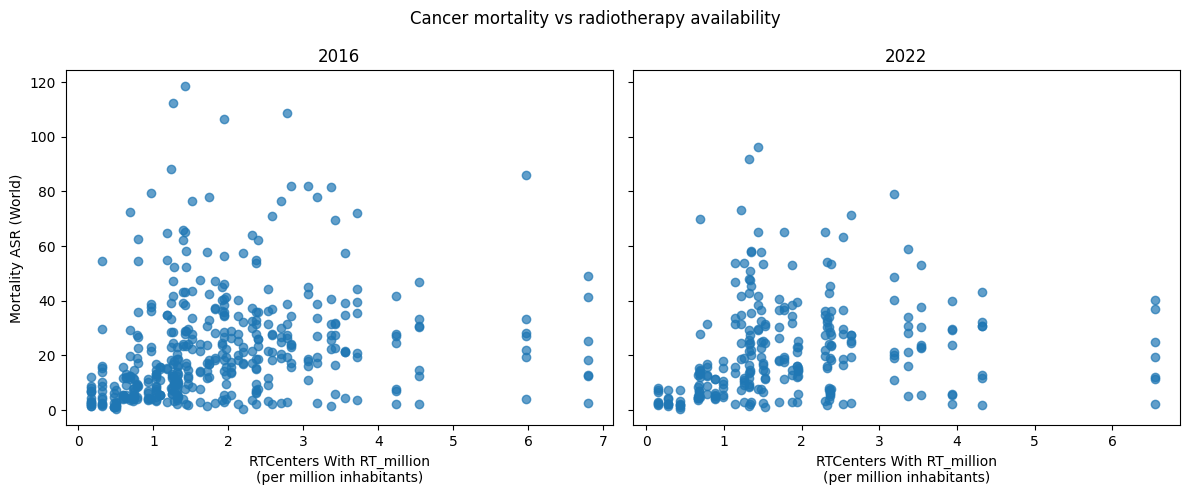

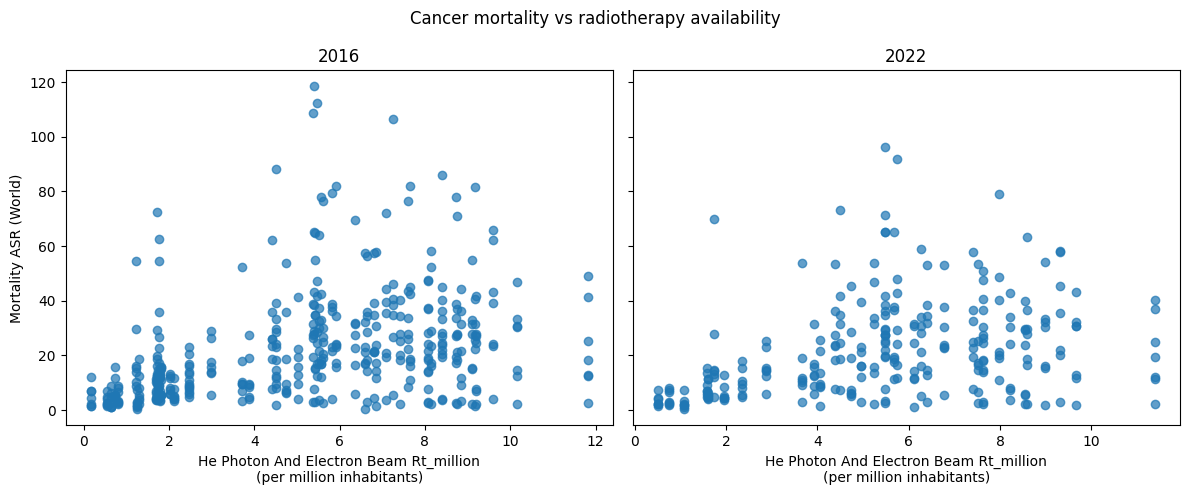

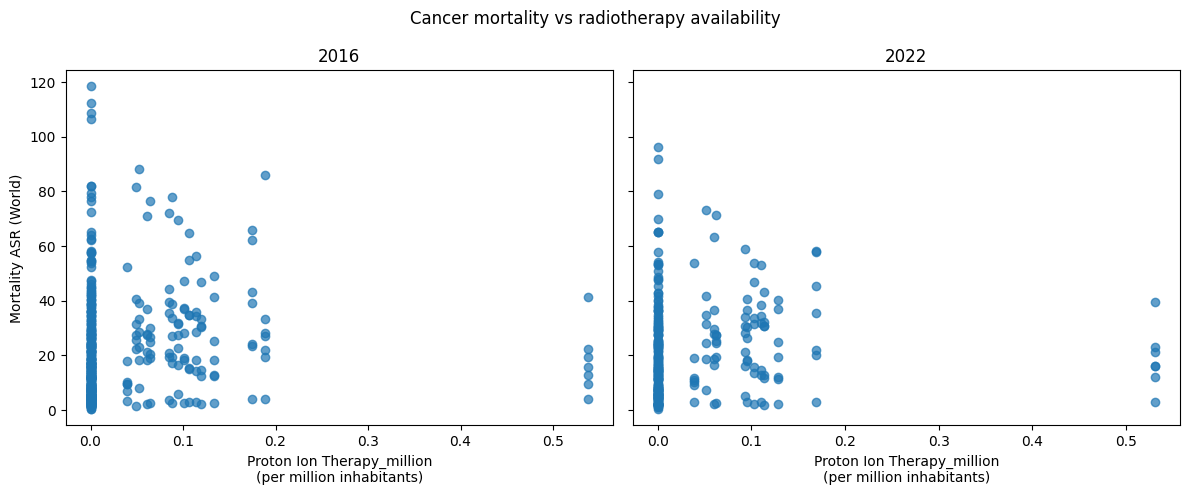

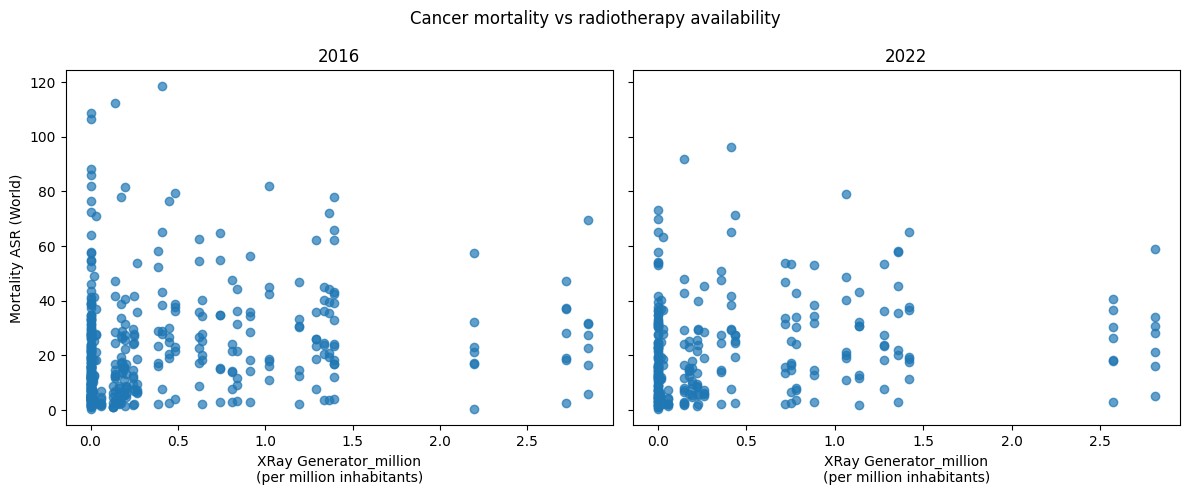

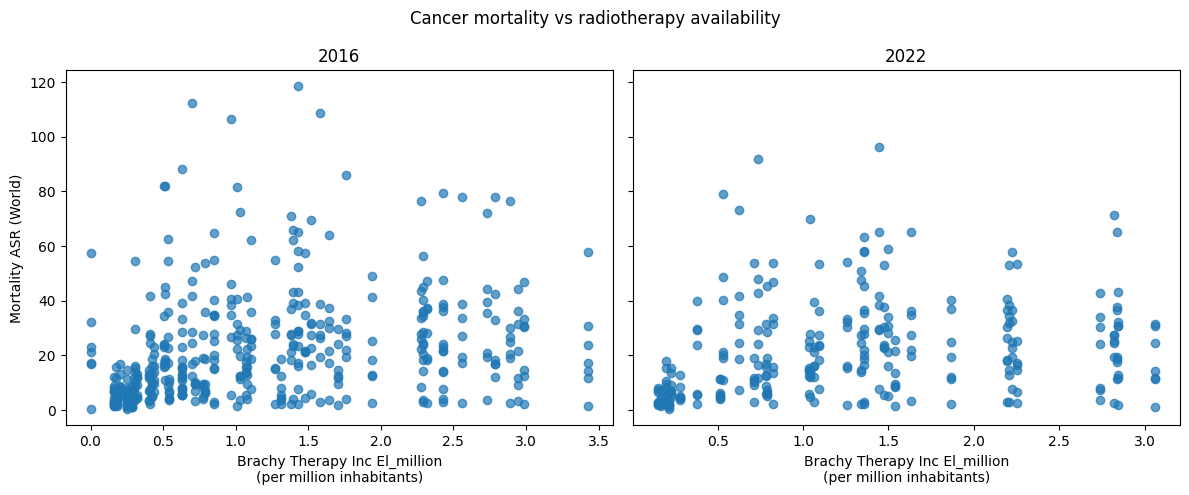

In [73]:
for var_pm in rt_vars_pm:
    scatter_mortality_vs_rt(
        df_merged_all,
        var_pm
    )


Los diagramas de dispersión que relacionan la mortalidad por cáncer con la disponibilidad de radioterapia por millón de habitantes para los años 2016 y 2022 no muestran una asociación lineal clara. Los valores de mortalidad presentan una elevada dispersión a lo largo de todo el rango de disponibilidad de infraestructura, lo que sugiere que la capacidad en radioterapia, por sí sola, no es suficiente para explicar las diferencias observadas en la mortalidad por cáncer entre países. Este resultado es coherente con la naturaleza multifactorial de los resultados en cáncer, que dependen no solo de la capacidad de tratamiento, sino también de factores como la detección precoz, el rendimiento del sistema sanitario, el acceso efectivo a la atención y los factores de riesgo a nivel poblacional.


Los datos del año 2022 son insuficientes limitando la robustez y por lo tanto no se dará el peso inferencial aunque se observa un patrón similar al global.

La relación entre incidencia y mortalidad se exploró mediante diagramas de dispersión basados en ASR World, donde cada punto representa un país, año y sexo. Esta gráfica nos muestra una tendencia lineal entre incidencia y mortalidad, y se ha resaltado los años que se desean estudiar por si tienen algún patrón distinto al resto, lo que sugiere que es tiene un comportamiento similar al resto de años, por lo tanto, son buenos candidatos para el estudio que haremos más delante.

# definimos el primer modelo base

el primer modelo relaciona mortalidad con centros de rt por millón de habitantes

In [83]:
#definimos el primer modelo

df_model = df_merged_all[
    df_merged_all["Year"].isin([2016, 2022])
].copy()
df_model = df_model[df_model["Type"] == "Mortality"]


In [84]:
#creamos la funcion para el modelo

def fit_linear_model(df, x_var, y_var="ASR (World)"):
    X = df[[x_var]]
    X = sm.add_constant(X)   # intercepto
    y = df[y_var]

    model = sm.OLS(y, X).fit()
    return model


In [85]:
model_2016 = fit_linear_model(
    df_model[df_model["Year"] == 2016],
    "RTCenters With RT_million" # Corrected column name suffix from _per_million to _million
)

print(model_2016.summary())

                            OLS Regression Results                            
Dep. Variable:            ASR (World)   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.847
Date:                Sun, 25 Jan 2026   Prob (F-statistic):              0.175
Time:                        16:24:31   Log-Likelihood:                -1569.2
No. Observations:                 427   AIC:                             3142.
Df Residuals:                     425   BIC:                             3151.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [86]:
model_2022 = fit_linear_model(
    df_model[df_model["Year"] == 2022],
    "RTCenters With RT_million" # Corrected column name suffix from _per_million to _million
)

print(model_2022.summary())

                            OLS Regression Results                            
Dep. Variable:            ASR (World)   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.076
Date:                Sun, 25 Jan 2026   Prob (F-statistic):              0.151
Time:                        16:30:57   Log-Likelihood:                -922.62
No. Observations:                 266   AIC:                             1849.
Df Residuals:                     264   BIC:                             1856.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Con estos resultados se muestra que la infraestructura por si sola no explica la mortalidad entre países. El modelo resultante solamente explica el 0.4% de la variabilidad de la mortalidad.

In [ ]:
df_analysis = df_merged[
    (df_merged["Year"] == 2019) &
    (df_merged["Type_label"] == "Incidence")
].copy()


df_analysis.shape


## Descripción inicial de los datos
Vamos a hacer una descripción inicial de los datos


In [ ]:
#Información del Contenido
dt.info()

## Variable objetivo: creditability

 La variable **creditability** es la *calidad crediticia* de  cada cliente, es la variable a predecir. Toma originalmente dos valores (Buen Cliente y Mal Clioente). Esta es la variable objetivo, la variable evento

## Variables Predictoras o explicativas

Las 20 restantes variables del data frame (7 numéricas y 13 categóricas) son los atributos o características observadas de esos clientes que se utilizarán para predecir la probabilidad de que los clientes cometan un impago de sis créditos, esto es, de que sean malos clientes. La descripción de estas 20 variables es la siguiente:


## Analisis univariante y de asociación con la variable objetivo

Que comprobar en el análisis descriptivo inicial?

### **Análisis univariante**

1- **Tipos de variables**. Todas las variables categóricas (factores) están bien identificadas?


Para el análisis univariante es importante realizar un análisis gráfico con el **Histograma de Frecuencias**

2- **Límites de las variables cuantitativas** Valores numéricos fuera de rango ¿Hay alguna limitación sobre el rango de alguna variable que no se cumpla?

3- **Niveles de las variables cualitativas**, Valores mal codificados ¿los niveles de las variables cualitativas tienen sentido? ¿Hay missings no declarados tipo -1, 99999? Las categorías de las nominales son las que deben?

4- **Variables nominales o categóricas o factores con categorías minoritarias**.Frecuencia de las categorías de las variables cualitativas.  Las categorías con baja representación puede causar muchos problemas en los modelos por falta de base muestral para la estimación de los parámetros correspondientes a la pertenencia a esa categoría. Por ello, es conveniente echar un vistazo y recodificar las vairables uniendo categorías muy poco representativas con otras cuya unión tenga algún sentido (tienen comportamiento similar frente a la objetivo, la variable tiene caracter ordinal por lo que la unión con mayor sentido sería hacia categorías adyacentes..).  Es imprescindible que todas los niveles de las variables cualitativas esten ´ bien representados pues, de lo contrario, se podr´ıan detectar patrones que no fueran extrapolables al estar basados en muy pocas observaciones.
 Por ello, se debe verificar que la frecuencia de todas ellas sea superior al 2-5 % (el porcentaje exacto depende del numero de observaciones del conjunto de datos) Yo prefiero que haya variabilidad suficiente: NO debe haber categorías con menos de un 5% de representación).

5 **Variabilidad suficiente de las variables numéricas** Por encima de un 5% de valores distintos


Con estas cosas ya arregladas, nos vamos a los dos grandes "caballos de batalla" de la depuración.

5- **Outliers**. Incidencia y tratamiento (pasar a missing, eliminar, winsorizar o reemplazarlos con los valores no atípicos más cercanos)

**Análisis de las variables/casos ausentes**


6- **Missings**. Incidencia y tratamiento
  - **Imputación** por valores validos (0-5%):  simple por media, mediana, aleatorio, imputación por modelos
  - **Recategorizacion** (5%- 50%) de los valores missing como una categoría valida.
  - **Eliminar** columnas u observaciones (superior al 50 %) Cuando en una variable hay mas de la mitad de los datos faltantes, es recomendable rechazarla al inicio del proceso, pues carece de suficiente informacion.
  

### **Análisis Bivariante**
**Después del análisis Univariante se realiza el Análisis Bivariante, entre cada una de las potenciales variables explicativas y la Variable objetivo**

a. Tablas de contigencia Chi2 (¿discretizar variables continuas V de Cramer o Chi2 dnormalizado entre 0 y 1,, independientes y totalmente dependientes respectivamente))
b. Tablas de correlaciones
c. Tablas Pivote (test de diferencia de medias)

c) Métodos gráficos:
  - Gráficos de dispersión
  - Diagrama de Cajas o boxplot (o diagrama de barras)
  - diagrams de mosaicos



***


## Análisis exploratorio inicial de las **variables categóricas**

Comenzamos con el análisis de las variables discretas

In [ ]:
dt.describe(include='object')

### **status.of.existing.checking.account**

In [ ]:
# tabla de distribución de frecuencia univariante
dt['status.of.existing.checking.account'].value_counts(normalize=True,dropna=False).sort_index()

In [ ]:
# tabla de contingencia: distribución de frecuencias bi-variante
ctabla=pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True).round(3)
ctabla

In [ ]:
# test Chi-cuadrado de independencia (Ho: ausencia de asociación)
c, p, dof, expected = chi2_contingency(ctabla)
# Print the p-value
print(p)

In [ ]:
# tabla de contingencia agrupada por columnas (axis=1), Se puede analizar la importancia relativa comparando con los porcentajes clobales.
pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True, normalize=1).round(3)

In [ ]:
# Porcentajes respecto al total de cada fila (normalize=0), habría que comparar con el porcentaje de eventos en el total de la muestra (30%)
pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True, normalize=0).round(3)

In [ ]:
pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))


In [ ]:
# Para comparar respecto a los totales

pd.crosstab(dt['status.of.existing.checking.account'], dt['y'], margins=True, normalize=0).round(3).plot(figsize=(15, 5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

### **Personal status and sex**

In [ ]:
dt['personal.status.and.sex'].value_counts(normalize=True,dropna=False).sort_index()

In [ ]:
ctabla=pd.crosstab(dt['personal.status.and.sex'],dt['y'],margins=True).round(3)
ctabla

In [ ]:
# test Chi-cuadrado de independencia (Ho: ausencia de asociación)
c, p, dof, expected = chi2_contingency(ctabla)
# Print the p-value
print(p)

In [ ]:
pd.crosstab(dt['personal.status.and.sex'],dt['y'],margins=True, normalize=0).round(3)

In [ ]:
pd.crosstab(dt['personal.status.and.sex'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

### **Housing**

In [ ]:
dt['housing'].value_counts(normalize=True,dropna=False).sort_index()

In [ ]:
ctabla=pd.crosstab(dt['housing'],dt['y'],margins=True).round(3)
ctabla

In [ ]:
# test Chi-cuadrado de independencia (Ho: ausencia de asociación)
c, p, dof, expected = chi2_contingency(ctabla)
# Print the p-value
print(p)

In [ ]:
pd.crosstab(dt['housing'],dt['y'],margins=True, normalize=0).round(3)

In [ ]:
pd.crosstab(dt['housing'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

### **Job**

In [ ]:
dt['job'].value_counts(normalize=True,dropna=False).sort_index()

In [ ]:
ctabla=pd.crosstab(dt['job'],dt['y'],margins=True).round(3)
ctabla

In [ ]:
# test Chi-cuadrado de independencia (Ho: ausencia de asociación)
c, p, dof, expected = chi2_contingency(ctabla)
# Print the p-value
print(p)

In [ ]:
pd.crosstab(dt['job'],dt['y'],margins=True, normalize=0).round(3)

In [ ]:
pd.crosstab(dt['job'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

 ....  Habría que seguir haciendo esto con todas las variables categóricas para analizar asociación

## Analisis univariante y de asociación con la variable objetivo de las **Variables continuas**

In [ ]:
dt.describe()

### **Credit.amount**

In [ ]:
sns.displot(x=(dt['credit.amount']), kind="kde", fill=True)
plt.show()

Parece que como la mayoría de variables económicas tipo cantidad de dinero (precios, salarios, rentas, etc) se comportan como una log normal. Lo comprobamos gráficamente

In [ ]:
sns.displot(x=np.log(dt['credit.amount']), kind="kde", fill=True)
plt.show()

Vamos a transformar la variable 'credit.amount' en logaritmos para conseguir normalidad (o al menos que se parezca a una normal)

In [ ]:
dt['credit.amount']=np.log(dt['credit.amount'])

Ahora vamos a ver si hay diferencias en la distribución de la variable 'credit.amount' entre los buenos y los malos clientes

In [ ]:
sns.displot(x=(dt['credit.amount']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

Según el histograma sí parece haber asociación, al menos hay tres tramos bien diferenciados, uno primero donde es difícil diferenciar entre los buenos y malos, otro tramo donde hay una mayor cantidad relativa de buenos clientes, y un tercero, en el que a partir de una determinada cantidad de crédito hay una mayoría relativa de malos clientes.    

Parece por tanto que sí hay asociación entre creditability (impago) y la cantidad de dinero que se solicita en el préstamo. PAra comprobarlo hacemos el test de diferencias de medias (Ho:igualdad de medias, esto es, ausencia de asociación)

In [ ]:
fvalue, pvalue = f_oneway(dt.loc[dt["y"]==0,['credit.amount']], dt.loc[dt["y"]==1,['credit.amount']])
print(fvalue, pvalue)


Hacemos la misma comprobación con el resto de variables

### **duration.in.month**

In [ ]:
sns.displot(x=(dt['duration.in.month']), kind="kde", fill=True)
plt.show()

In [ ]:
sns.displot(x=(dt['duration.in.month']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

In [ ]:
fvalue, pvalue = f_oneway(dt.loc[dt["y"]==0,['duration.in.month']], dt.loc[dt["y"]==1,['duration.in.month']])
print(fvalue, pvalue)

Tendría que continuar con el análisis del resto de variables continuas .....

In [ ]:
sns.pairplot(dt, hue="y")

# **Selección de Variables**: análisis de Concentración para seleccionar las variables más **importantes** para meter en el modelo

### Dividimos la muestra en entrenamiento y test     

Comenzamos ya el proceso de construcción del modelo en sentido estricto. Por eso lo primero es partir la muestra para comprobar la bondad del modelo que estimemos.



In [ ]:
dt_train, dt_test = train_test_split(dt,stratify=dt["y"], test_size=.25, random_state=1234)

In [ ]:
# Realizamos la trimificación optima de age.in.years
variable="age.in.years"
X=dt_train[variable].values
Y=dt_train['y'].values
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb.fit(X, Y)
optb.splits
binning_table = optb.binning_table
binning_table.build()

In [ ]:
dt_train["y"].shape

In [ ]:
dt_train["y"].mean()

In [ ]:
dt_test["y"].shape

In [ ]:
dt_test["y"].mean()

## Defino la tramificación óptima

## Tramificación de la Variable: "credit.amount"

In [ ]:
variable="credit.amount"
X=dt_train[variable].values
Y=dt_train['y'].values

In [ ]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

# Si se quisiese fijar los intervalos manualmente (porque no gusten los que obtine el agoritmo, entonces habría que usar:
#                     user_splits=
#                     user_splits_fixed=
# HAy veces que los datos tienen dátos missing y códigos especiales en este caso para obtener una categoría con esos datos missing y datos especiales hay que establecerlos
#                     special_codes = [-9, -8, -7]

# Una vez definido podemos pasar a estimarlo
optb.fit(X, Y)
optb.splits

Nota: Por defecto se utiliza un arbol de clasificación para hacer una tramificación inicial, y después se aplica un proceso de optimización de agrupación de categorías para maximizar el Valor de Información

Una vez realizado el proceso de tramificación y agrupación óptima de categorías, obtenemos la tabla de agrupación

In [ ]:
binning_table = optb.binning_table
binning_table.build()

Cabe mencionar que el WOE en esta tabla parece estar definido al revés que lo hemos hecho en clase, por lo que el signo es justo el contrario al que cabría esperar según lo que hemos visto en clase. En particular por defecto `optbinning` define el WOE de una categoría $i$ como
$$ WOE_i =  ln \left ( {Non-event_i \over Non-event_{total}} \over {Event_i \over Event_{total}}    \right ) $$

En este sentido los niveles con mayor tasa de impagados tendrán un WOE menos, y a medida que se reduzca la tasa de impagados (mejor calidad crediticia) irá aumentando el WOE. De hecho, 'optbinning' ni siquiera utiliza la misma fórmula que yo he utilizado en clase, por lo que no está acotada entre cero y uno, puede valos más que uno sin que eso signifique sobre ajuste.

Por talmotivo utilizaremos como criterio de selección exclusivamente IV<0.002

Podemos extraer el IV y el índice de Gini a partir de la tabla

# Agrupción de niveles en variables Vbles Categóricas

En realidad, cuando tenemosvariables categóricas, no es necesario tramificar, pero sí hacer una agrupación de los diferentes niveles de forma que se maximice el *valor de información*

## Agrupación de la variable  *purpose*

# Estimación del Modelo

Ahora podemos calcular la tarjeta de puntuación. En los apuntes de clase definimos tanto los WOE, como los Odd ratio como la probabilidad de `evento` respecto al `no-evento` (malos clientes o impago=1 respecto a los buenos clientes o impago=0):

$$ odd = {{P}\over {(1-P)}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$

 Y la fórmula para obtener la puntuación o los score debe ser una relación negativa con los odd ratio: cuanto mayor la probabilidad de impago (en relación a la de no impago), menor puntuación ha de tener:

 $$ score {= offset - Factor}~·~{ln(odds)}$$

Para pasar de Probabiliddes de impago a Puntuaciones, habrá que establecer tanto el valor de `offset` como el de `Factor`. Esto se hace de manera arbitraria dependiendo de cada institución financiera.

En general, para determinar estos dos valores es necesario establecer la pendiente de la recta y un punto de la misma.

En cuanto a la pendiente, cuanto más plana sea la pendiente, menor variabilidad tendrán los valores de puntuación de crédito que se alcancen, y al revés, cuanto mayor pendiente más diferencias en la puntuación final. Yo voy a utilizar un apendiente (arbitraria) estableciendo de forma arbitraria cada cuantos puntos de score (**pdo_0**) se dobla el odd ratio: $ score - pdo_0 = {offset -Factor}~ ·{ln(2*odds)}$.

 En cuanto al punto de la recta (arbitrario), puede hacerse estableciento (de manera arbitraria) la puntuación o score considerada como de sobresaliente(**scorecard_points**) y el odd ratio que debería tener ese cliente de *sobresaliente* (**odds_0**)

 Así habría que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40  (esto es que cada 40 puntos de calidad creditica se dobla el odd-ratio))
* **scorecard_points** =600  (alguien con calidad crediticia muy buena, de sobresaliente, sacaría 600 puntos)
* **odds_0** =1/50  (odd ratio que se considera de sobresaliente)

La librería `optBinning` [librería OptBinning](http://gnpalencia.org/optbinning/), en realidad utiliza el módulo de `credit scoring` de `SAS-miner` como inspiración, y por eso define al revés tanto los WOE como los odd ratio, es decir `no-evento` en relación a `evento` (clientes buenos respecto a los malos, o no-impago respecto a impago, impago=0 respecto a impago=1).
$$ odd^B = {{(1-P)}\over {P}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$

Esto implica que la ecuación que transforma las probabilidades de impago en scores utilizando esta *odds<sup>B</sup>* debe tener pendiente positiva (cuanto mejor *odd<sup>B</sup>* mejor calidad crediticia tiene el cliente)

 $$ score= {offset + Factor} ~·~ {ln(odds^B)}$$

 Nótese que ahora habrá que establecer de nuevo los puntos de score que doblan el odd ratio (**pdo_0**), y también la puntuación o score considerada como de sobresaliente(**scorecard_points**) y el odd ratio que debería tener ese cliente de *sobresaliente* **odds_0 <sup>*B*</sup>**, con **odds_0 <sup>*B*</sup>** **= 1/odds_0**.

 Así para estimar la puntuación crediticia con `optBinning` hay que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40
* **scorecard_points** =600
* **odds_0 <sup>*B*</sup>** = 50  (equivalente a **odds_0** =1/50 )


